# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## MNIST GAN 

**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Pavlos Protopapas, Mark Glickman and Chris Tanner<br/>
Author: Rashmi Banthia

<hr style="height:2pt">

##### Code merged from 
##### Tensorflow Tutorial - https://www.tensorflow.org/tutorials/generative/dcgan , Lab 10, ...


In [0]:
# system libraries 
import sys
import warnings
import os
import glob
import time
warnings.filterwarnings("ignore")

# math/numerical libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import tensorflow as tf

print(tf.__version__)

2.2.0-rc3


In [0]:
# from tqdm import tqdm_notebook

# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

In [0]:

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5 # Normalize the images to [-1, 1]


In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True)

In [0]:
z_dim = 100



def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    adam = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    #adam = tf.keras.optimizers.Adam(lr=0.0003)
    return model

g = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = g(noise, training=False)


In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

d = make_discriminator_model()
adam = tf.keras.optimizers.Adam(lr=0.0002) # 1e-4, beta_1=0.5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
d.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
decision = d(generated_image)
print (decision)

tf.Tensor([[0.00071759]], shape=(1, 1), dtype=float32)


In [0]:
# Create GAN
d.trainable = False
inputs = tf.keras.layers.Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = tf.keras.Model(inputs, output)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
adam = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.5)    
gan.compile(loss=loss, optimizer=adam, metrics=['accuracy'])

In [0]:
def show_images(imgs):
    n_imgs = imgs.shape[0]
    
    fig, ax = plt.subplots(1, n_imgs, figsize=(15, 20))
    plt.axis('off')
    for i in range(n_imgs):
        ax[i].imshow(np.clip(imgs[i].reshape(28,28), 0.0, 1.0), cmap='gray')
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()
    


In [0]:
d.metrics_names, gan.metrics_names #(['loss', 'accuracy'], ['loss', 'accuracy'])


([], [])

Epoch: 0 	 Discr. Loss Real: [0.3304795026779175, 0.0] 	 Discr. Loss Fake: [0.004458922892808914, 1.0] 	 DCGAN Loss: [0.002042971784248948, 1.0]
Time:  15.12735915184021


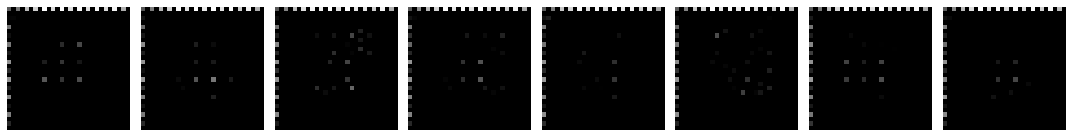

Epoch: 1 	 Discr. Loss Real: [0.8123246431350708, 0.0] 	 Discr. Loss Fake: [0.5237945914268494, 0.9140625] 	 DCGAN Loss: [1.0791841745376587, 0.03125]
Time:  13.376353979110718


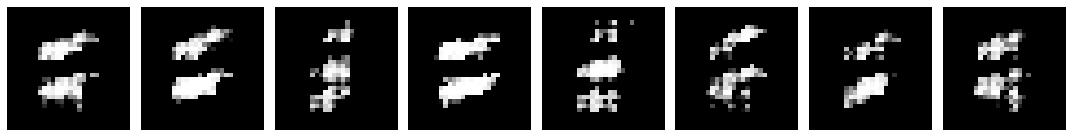

Epoch: 2 	 Discr. Loss Real: [0.7571982741355896, 0.0] 	 Discr. Loss Fake: [0.6046732068061829, 0.96484375] 	 DCGAN Loss: [0.8929339051246643, 0.015625]
Time:  13.366743803024292


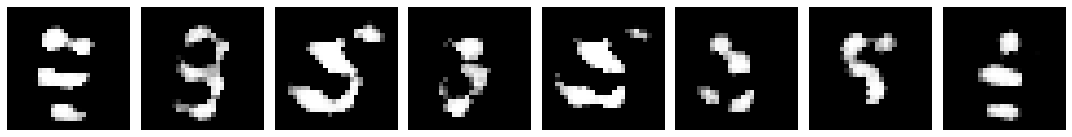

Epoch: 3 	 Discr. Loss Real: [0.6901211738586426, 0.0] 	 Discr. Loss Fake: [0.5569086670875549, 0.97265625] 	 DCGAN Loss: [0.7923485636711121, 0.03515625]
Time:  13.194305896759033


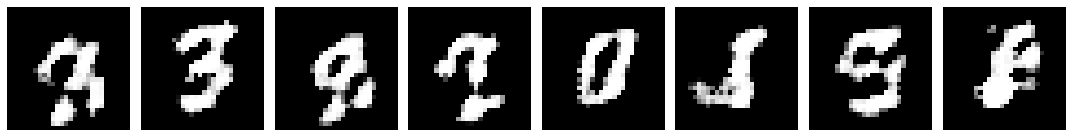

Epoch: 4 	 Discr. Loss Real: [0.7896780371665955, 0.0] 	 Discr. Loss Fake: [0.6122182607650757, 0.96484375] 	 DCGAN Loss: [0.800103485584259, 0.0234375]
Time:  13.174542665481567


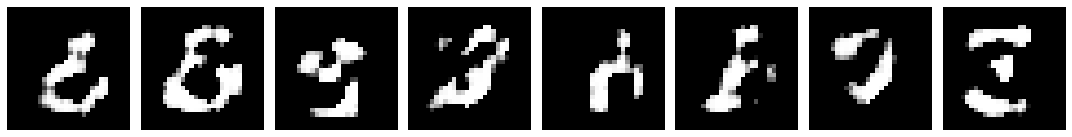

Epoch: 5 	 Discr. Loss Real: [0.7865121364593506, 0.0] 	 Discr. Loss Fake: [0.562225341796875, 0.9921875] 	 DCGAN Loss: [0.8869153261184692, 0.0]
Time:  13.387238502502441


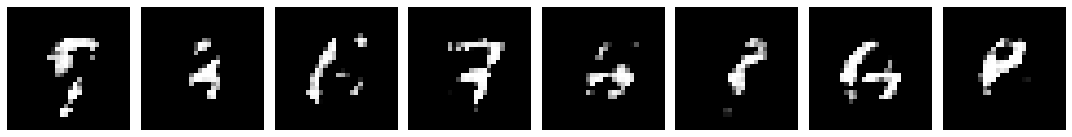

Epoch: 6 	 Discr. Loss Real: [0.7554413080215454, 0.0] 	 Discr. Loss Fake: [0.600699782371521, 1.0] 	 DCGAN Loss: [0.8833107352256775, 0.0]
Time:  13.316084861755371


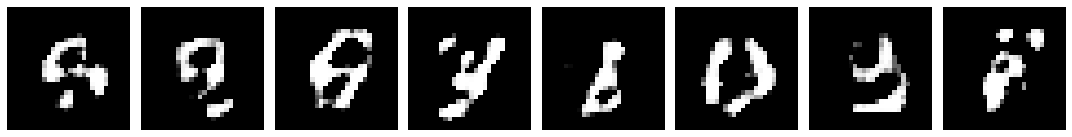

Epoch: 7 	 Discr. Loss Real: [0.6834360361099243, 0.0] 	 Discr. Loss Fake: [0.6062121391296387, 0.984375] 	 DCGAN Loss: [0.7629005312919617, 0.01171875]
Time:  13.42140007019043


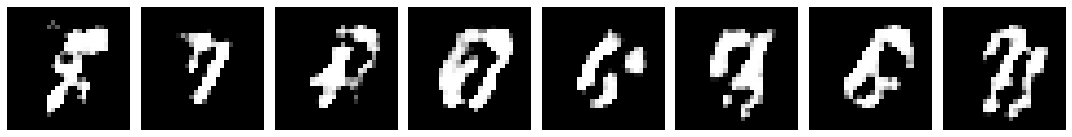

Epoch: 8 	 Discr. Loss Real: [0.7758355736732483, 0.0] 	 Discr. Loss Fake: [0.5973025560379028, 0.97265625] 	 DCGAN Loss: [0.7682034969329834, 0.03125]
Time:  13.308878898620605


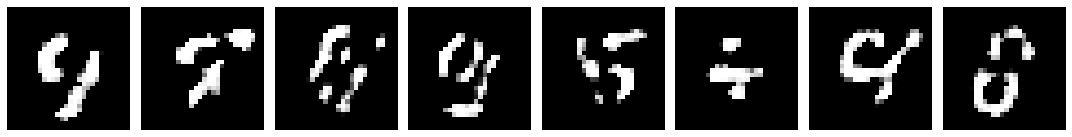

Epoch: 9 	 Discr. Loss Real: [0.8613510727882385, 0.0] 	 Discr. Loss Fake: [0.6112769842147827, 1.0] 	 DCGAN Loss: [0.8883019685745239, 0.0]
Time:  13.47832179069519


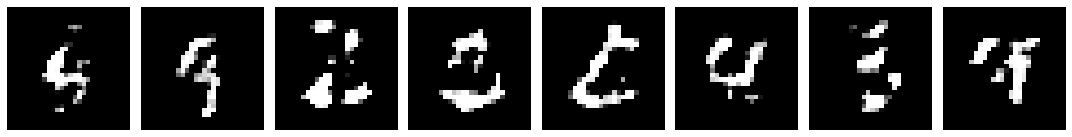

Epoch: 10 	 Discr. Loss Real: [0.764971137046814, 0.0] 	 Discr. Loss Fake: [0.5613496899604797, 1.0] 	 DCGAN Loss: [0.8807052969932556, 0.0]
Time:  13.294067621231079


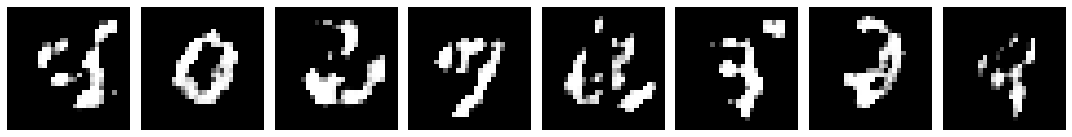

Epoch: 11 	 Discr. Loss Real: [0.7320764660835266, 0.0] 	 Discr. Loss Fake: [0.5713137984275818, 0.99609375] 	 DCGAN Loss: [0.8249409794807434, 0.00390625]
Time:  13.434141397476196


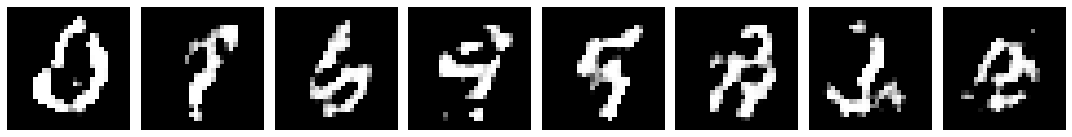

Epoch: 12 	 Discr. Loss Real: [0.7696123123168945, 0.0] 	 Discr. Loss Fake: [0.6129961013793945, 0.98828125] 	 DCGAN Loss: [0.8139655590057373, 0.0234375]
Time:  13.069379329681396


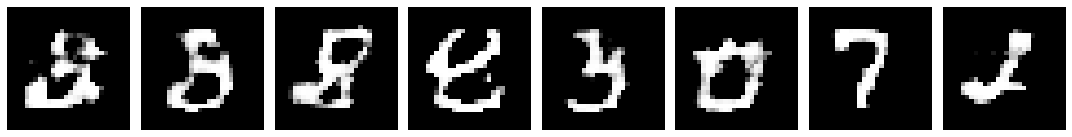

Epoch: 13 	 Discr. Loss Real: [0.7607884407043457, 0.0] 	 Discr. Loss Fake: [0.6054296493530273, 0.9921875] 	 DCGAN Loss: [0.8054090142250061, 0.0234375]
Time:  13.453974962234497


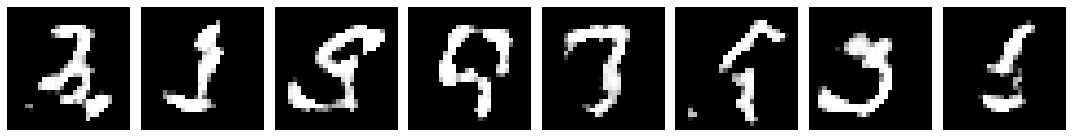

Epoch: 14 	 Discr. Loss Real: [0.7577080726623535, 0.0] 	 Discr. Loss Fake: [0.6303883790969849, 0.98046875] 	 DCGAN Loss: [0.8042701482772827, 0.015625]
Time:  13.208017110824585


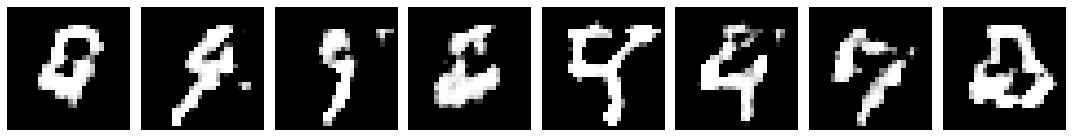

Epoch: 15 	 Discr. Loss Real: [0.7537000179290771, 0.0] 	 Discr. Loss Fake: [0.6353610754013062, 0.99609375] 	 DCGAN Loss: [0.7747070789337158, 0.01171875]
Time:  13.131238222122192


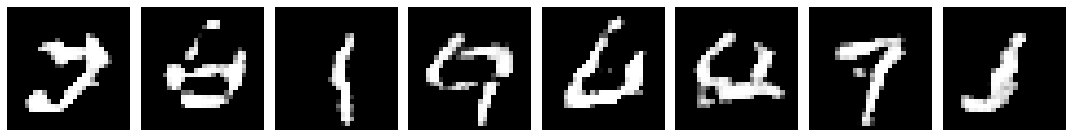

Epoch: 16 	 Discr. Loss Real: [0.7574318051338196, 0.0] 	 Discr. Loss Fake: [0.7035331726074219, 0.93359375] 	 DCGAN Loss: [0.7527843117713928, 0.015625]
Time:  13.653627157211304


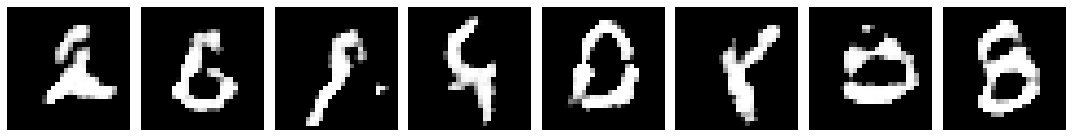

Epoch: 17 	 Discr. Loss Real: [0.7812764048576355, 0.0] 	 Discr. Loss Fake: [0.5930922627449036, 1.0] 	 DCGAN Loss: [0.8275468945503235, 0.00390625]
Time:  13.27401065826416


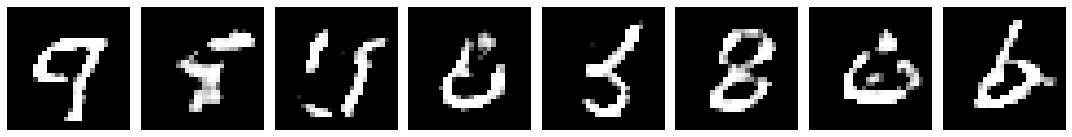

Epoch: 18 	 Discr. Loss Real: [0.7491901516914368, 0.0] 	 Discr. Loss Fake: [0.670415997505188, 0.9765625] 	 DCGAN Loss: [0.7513033151626587, 0.01171875]
Time:  13.489809274673462


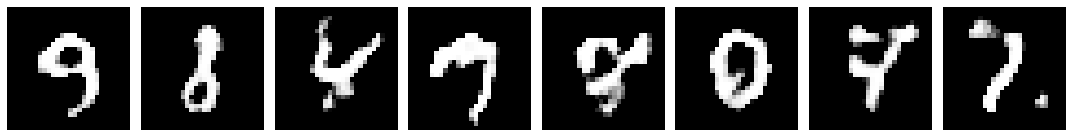

Epoch: 19 	 Discr. Loss Real: [0.7752203345298767, 0.0] 	 Discr. Loss Fake: [0.6535983085632324, 0.98828125] 	 DCGAN Loss: [0.7743932008743286, 0.0]
Time:  13.35570764541626


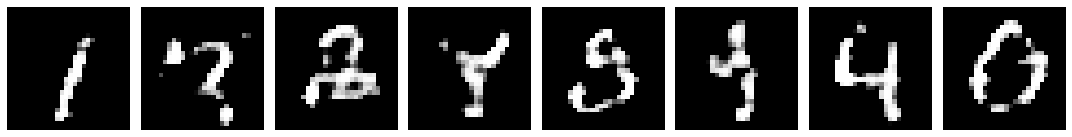

Epoch: 20 	 Discr. Loss Real: [0.8635933995246887, 0.0] 	 Discr. Loss Fake: [0.546097457408905, 1.0] 	 DCGAN Loss: [0.9167377948760986, 0.0]
Time:  13.304770946502686


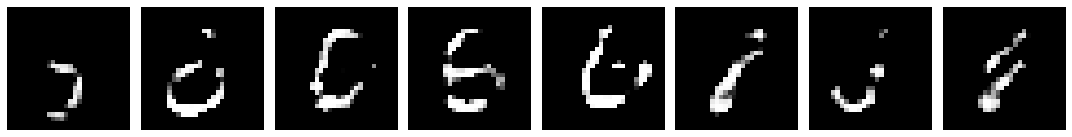

Epoch: 21 	 Discr. Loss Real: [0.7369406223297119, 0.0] 	 Discr. Loss Fake: [0.6214733123779297, 1.0] 	 DCGAN Loss: [0.7949162721633911, 0.00390625]
Time:  13.380877256393433


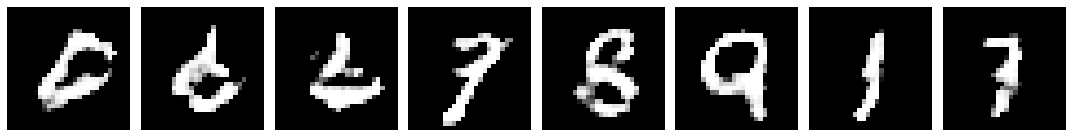

Epoch: 22 	 Discr. Loss Real: [0.7492828369140625, 0.0] 	 Discr. Loss Fake: [0.6291493773460388, 1.0] 	 DCGAN Loss: [0.7804789543151855, 0.00390625]
Time:  13.05168080329895


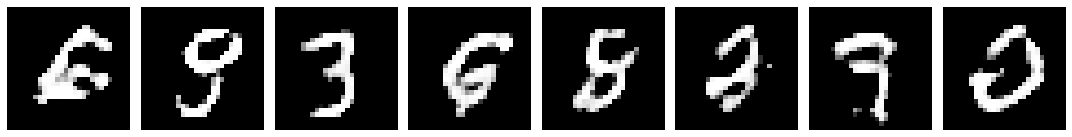

Epoch: 23 	 Discr. Loss Real: [0.7364211082458496, 0.0] 	 Discr. Loss Fake: [0.6469336748123169, 1.0] 	 DCGAN Loss: [0.758234441280365, 0.0]
Time:  13.112936973571777


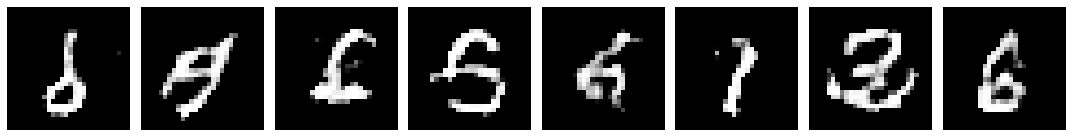

Epoch: 24 	 Discr. Loss Real: [0.7648439407348633, 0.0] 	 Discr. Loss Fake: [0.5969140529632568, 1.0] 	 DCGAN Loss: [0.812292754650116, 0.0]
Time:  13.223097562789917


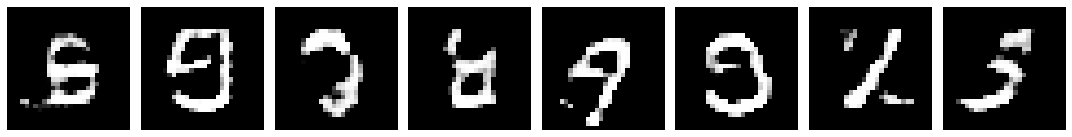

Epoch: 25 	 Discr. Loss Real: [0.756790041923523, 0.0] 	 Discr. Loss Fake: [0.6395696401596069, 1.0] 	 DCGAN Loss: [0.7635027766227722, 0.0]
Time:  13.339717626571655


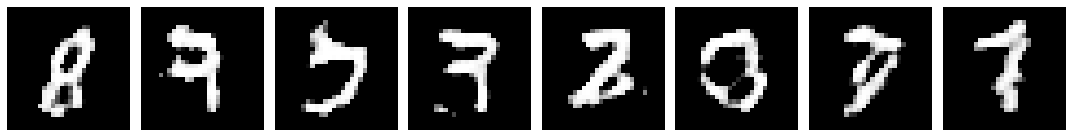

Epoch: 26 	 Discr. Loss Real: [0.777198076248169, 0.0] 	 Discr. Loss Fake: [0.6256390810012817, 1.0] 	 DCGAN Loss: [0.7829263806343079, 0.0]
Time:  13.308679819107056


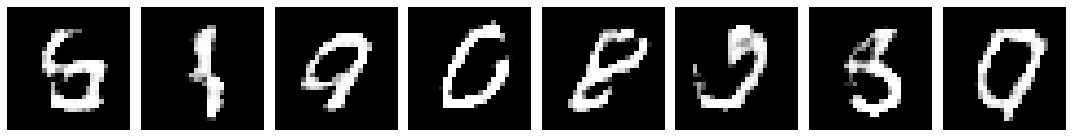

Epoch: 27 	 Discr. Loss Real: [0.8152098655700684, 0.0] 	 Discr. Loss Fake: [0.5530313849449158, 1.0] 	 DCGAN Loss: [0.8746933937072754, 0.0]
Time:  13.206161260604858


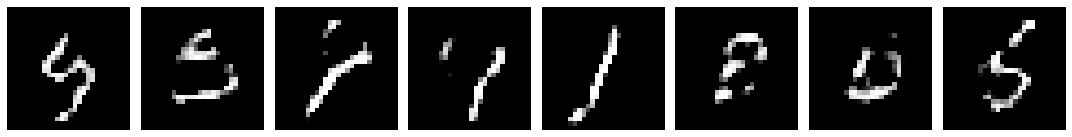

Epoch: 28 	 Discr. Loss Real: [0.725290060043335, 0.0] 	 Discr. Loss Fake: [0.6020523309707642, 1.0] 	 DCGAN Loss: [0.8001883029937744, 0.0]
Time:  13.063731670379639


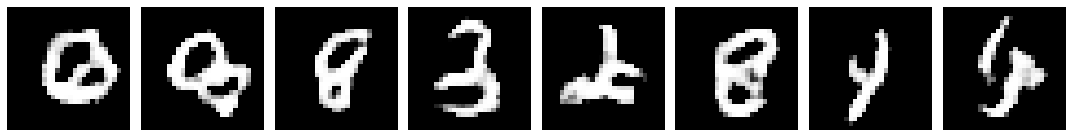

Epoch: 29 	 Discr. Loss Real: [0.8306465148925781, 0.0] 	 Discr. Loss Fake: [0.5272054672241211, 1.0] 	 DCGAN Loss: [0.9067907333374023, 0.0]
Time:  13.245062589645386


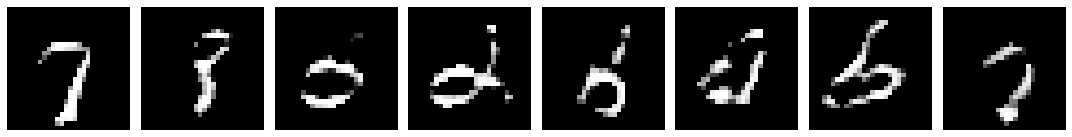

Epoch: 30 	 Discr. Loss Real: [0.754906952381134, 0.0] 	 Discr. Loss Fake: [0.6285392045974731, 1.0] 	 DCGAN Loss: [0.7676386833190918, 0.0]
Time:  13.329920530319214


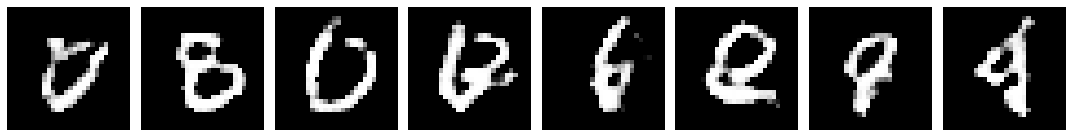

Epoch: 31 	 Discr. Loss Real: [0.837044894695282, 0.0] 	 Discr. Loss Fake: [0.511721134185791, 1.0] 	 DCGAN Loss: [0.9449840784072876, 0.0]
Time:  13.52677297592163


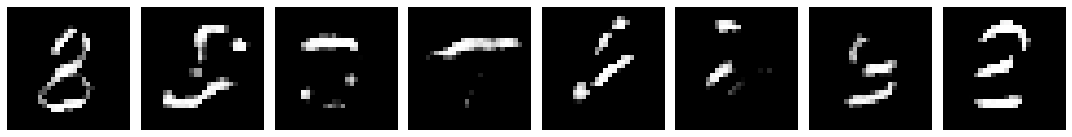

Epoch: 32 	 Discr. Loss Real: [0.7452620267868042, 0.0] 	 Discr. Loss Fake: [0.6368473768234253, 1.0] 	 DCGAN Loss: [0.7699548602104187, 0.0]
Time:  13.041725158691406


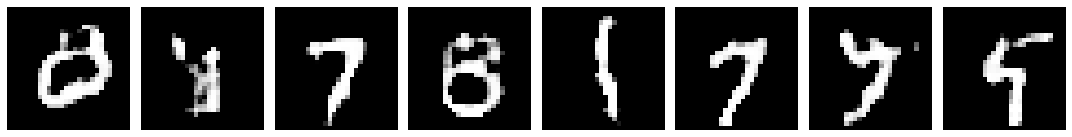

Epoch: 33 	 Discr. Loss Real: [0.817741870880127, 0.0] 	 Discr. Loss Fake: [0.5480141639709473, 1.0] 	 DCGAN Loss: [0.8649782538414001, 0.0]
Time:  13.177704572677612


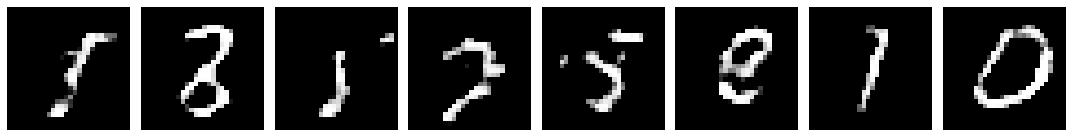

Epoch: 34 	 Discr. Loss Real: [0.7215809226036072, 0.0] 	 Discr. Loss Fake: [0.6459822654724121, 1.0] 	 DCGAN Loss: [0.7623864412307739, 0.0]
Time:  13.173400163650513


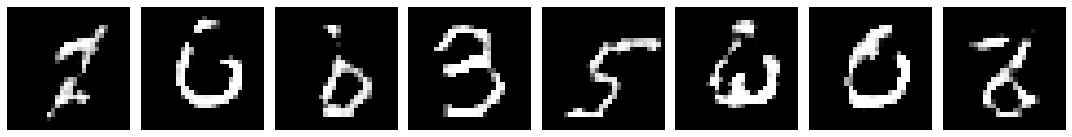

Epoch: 35 	 Discr. Loss Real: [0.8280104398727417, 0.0] 	 Discr. Loss Fake: [0.5510139465332031, 1.0] 	 DCGAN Loss: [0.887056827545166, 0.0]
Time:  13.339581727981567


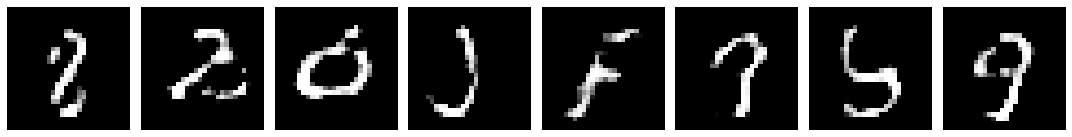

Epoch: 36 	 Discr. Loss Real: [0.7717896699905396, 0.0] 	 Discr. Loss Fake: [0.6280639171600342, 1.0] 	 DCGAN Loss: [0.7798154354095459, 0.0]
Time:  13.711843729019165


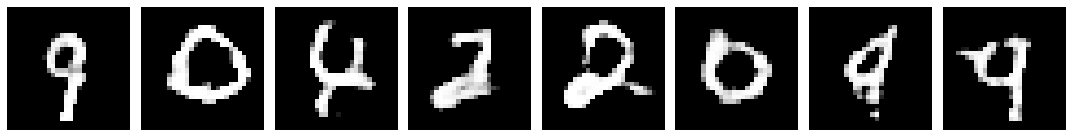

Epoch: 37 	 Discr. Loss Real: [0.8416098952293396, 0.0] 	 Discr. Loss Fake: [0.5809025764465332, 1.0] 	 DCGAN Loss: [0.8588997721672058, 0.0]
Time:  13.327078104019165


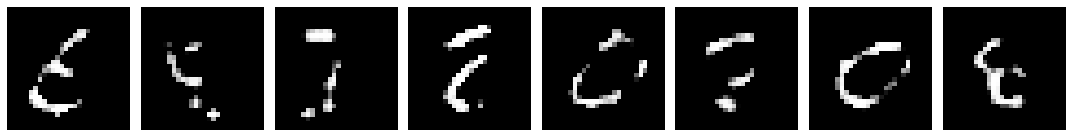

Epoch: 38 	 Discr. Loss Real: [0.7730007171630859, 0.0] 	 Discr. Loss Fake: [0.5870835781097412, 1.0] 	 DCGAN Loss: [0.8182154297828674, 0.0]
Time:  13.27609395980835


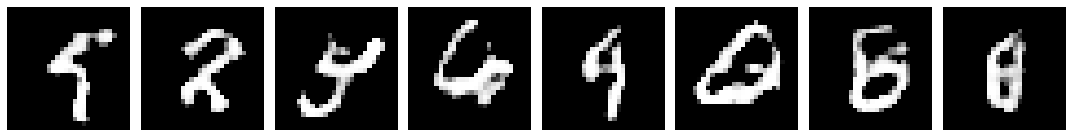

Epoch: 39 	 Discr. Loss Real: [0.7876288294792175, 0.0] 	 Discr. Loss Fake: [0.5914737582206726, 1.0] 	 DCGAN Loss: [0.8317956924438477, 0.0]
Time:  13.550852298736572


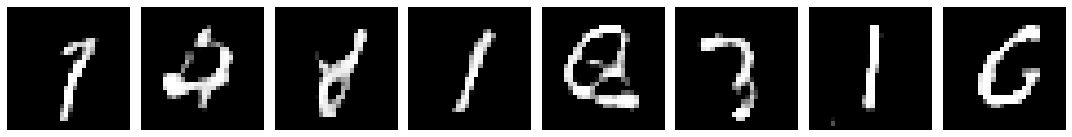

Epoch: 40 	 Discr. Loss Real: [0.7348607778549194, 0.0] 	 Discr. Loss Fake: [0.6730495095252991, 1.0] 	 DCGAN Loss: [0.7488758563995361, 0.0]
Time:  13.39736270904541


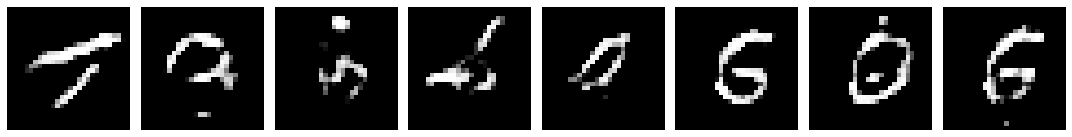

Epoch: 41 	 Discr. Loss Real: [0.7650274038314819, 0.0] 	 Discr. Loss Fake: [0.6233015060424805, 1.0] 	 DCGAN Loss: [0.7986366748809814, 0.0]
Time:  13.438606262207031


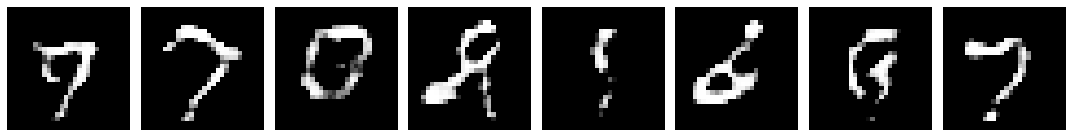

Epoch: 42 	 Discr. Loss Real: [0.7739418745040894, 0.0] 	 Discr. Loss Fake: [0.6072162985801697, 1.0] 	 DCGAN Loss: [0.803379237651825, 0.0]
Time:  13.076157808303833


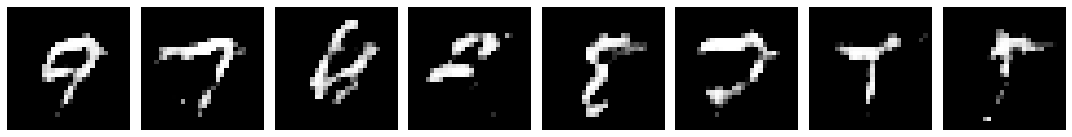

Epoch: 43 	 Discr. Loss Real: [0.8016402721405029, 0.0] 	 Discr. Loss Fake: [0.5807241201400757, 1.0] 	 DCGAN Loss: [0.8390459418296814, 0.0]
Time:  13.27420687675476


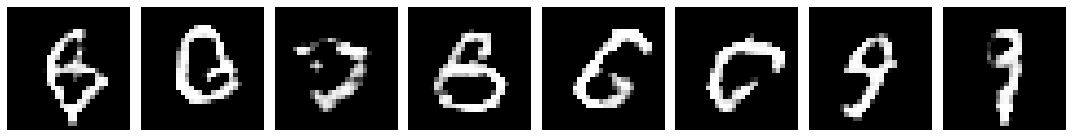

Epoch: 44 	 Discr. Loss Real: [0.7948965430259705, 0.0] 	 Discr. Loss Fake: [0.5865253806114197, 1.0] 	 DCGAN Loss: [0.8323901295661926, 0.0]
Time:  13.288832902908325


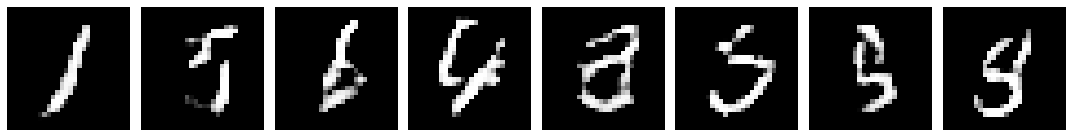

Epoch: 45 	 Discr. Loss Real: [0.7795223593711853, 0.0] 	 Discr. Loss Fake: [0.6042482852935791, 1.0] 	 DCGAN Loss: [0.814451277256012, 0.0]
Time:  13.115939378738403


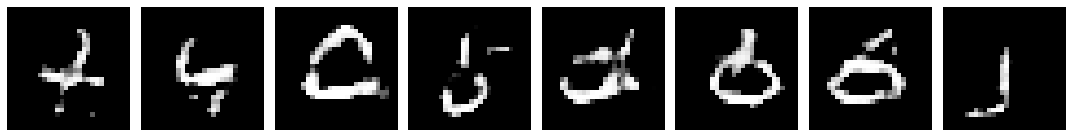

Epoch: 46 	 Discr. Loss Real: [0.7576521635055542, 0.0] 	 Discr. Loss Fake: [0.5880507230758667, 1.0] 	 DCGAN Loss: [0.8289406299591064, 0.0]
Time:  13.333478689193726


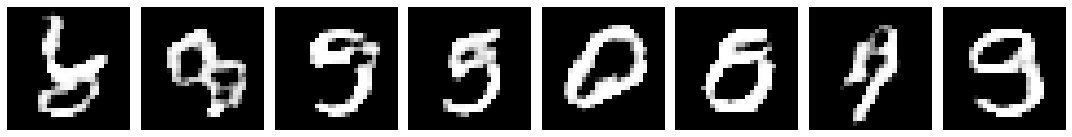

Epoch: 47 	 Discr. Loss Real: [0.7931133508682251, 0.0] 	 Discr. Loss Fake: [0.5920664668083191, 1.0] 	 DCGAN Loss: [0.8279386162757874, 0.0]
Time:  13.300652980804443


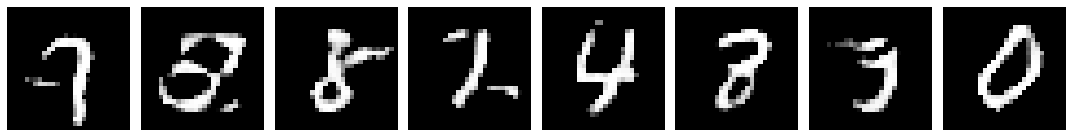

Epoch: 48 	 Discr. Loss Real: [0.7863439321517944, 0.0] 	 Discr. Loss Fake: [0.6226587295532227, 1.0] 	 DCGAN Loss: [0.7907770276069641, 0.0]
Time:  13.402754068374634


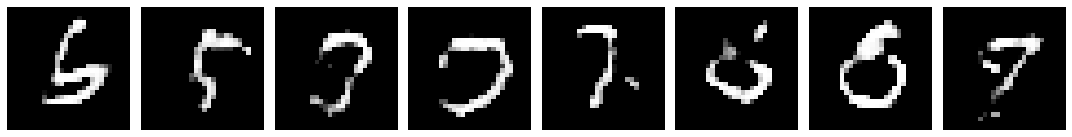

Epoch: 49 	 Discr. Loss Real: [0.74483323097229, 0.0] 	 Discr. Loss Fake: [0.6112197041511536, 1.0] 	 DCGAN Loss: [0.7646615505218506, 0.0]
Time:  13.359896898269653


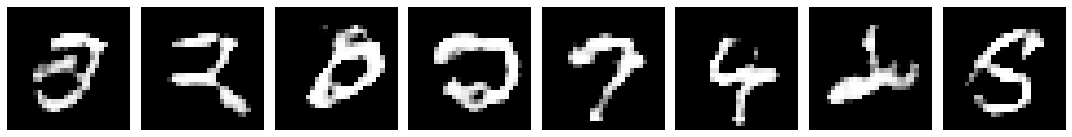

Epoch: 50 	 Discr. Loss Real: [0.802431583404541, 0.0] 	 Discr. Loss Fake: [0.592049241065979, 1.0] 	 DCGAN Loss: [0.822918176651001, 0.0]
Time:  13.373165369033813


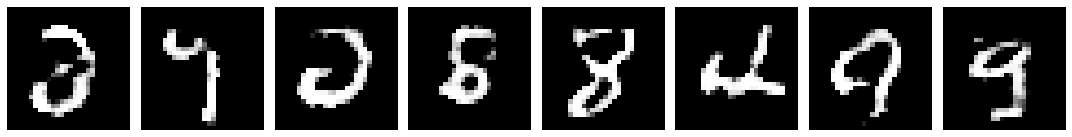

Epoch: 51 	 Discr. Loss Real: [0.7788832187652588, 0.0] 	 Discr. Loss Fake: [0.5887942314147949, 1.0] 	 DCGAN Loss: [0.8356075286865234, 0.0]
Time:  13.640733003616333


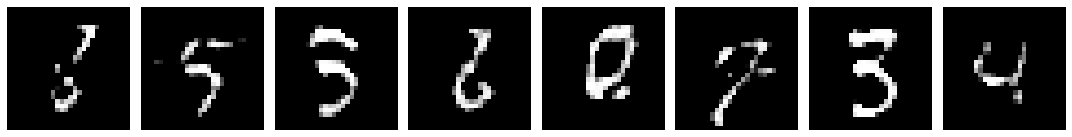

Epoch: 52 	 Discr. Loss Real: [0.7590558528900146, 0.0] 	 Discr. Loss Fake: [0.6176404356956482, 1.0] 	 DCGAN Loss: [0.7936220765113831, 0.0]
Time:  13.29168701171875


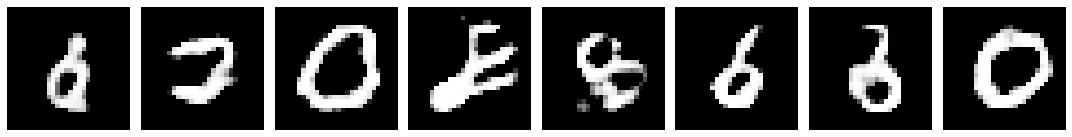

Epoch: 53 	 Discr. Loss Real: [0.8120222687721252, 0.0] 	 Discr. Loss Fake: [0.5581284165382385, 1.0] 	 DCGAN Loss: [0.8798789978027344, 0.0]
Time:  13.19653844833374


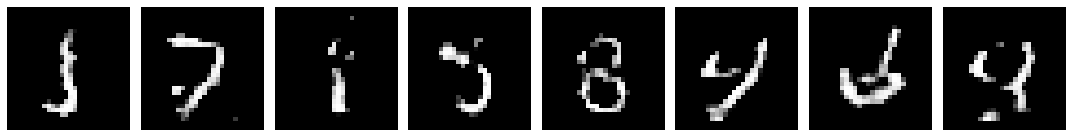

Epoch: 54 	 Discr. Loss Real: [0.7609716653823853, 0.0] 	 Discr. Loss Fake: [0.5972251296043396, 1.0] 	 DCGAN Loss: [0.8060594797134399, 0.0]
Time:  13.131348609924316


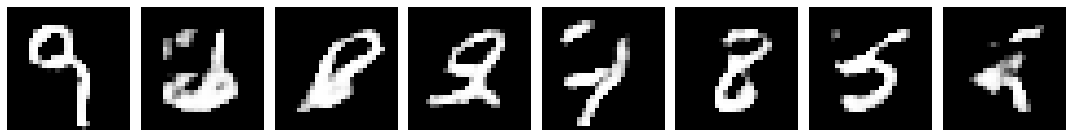

Epoch: 55 	 Discr. Loss Real: [0.7939940094947815, 0.0] 	 Discr. Loss Fake: [0.5889520049095154, 1.0] 	 DCGAN Loss: [0.8250802755355835, 0.0]
Time:  13.106643676757812


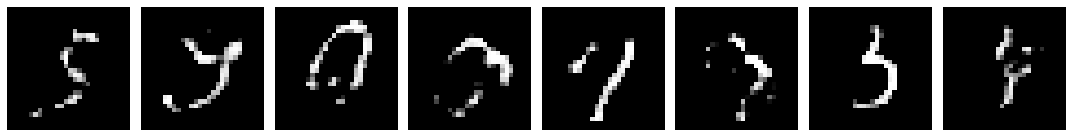

Epoch: 56 	 Discr. Loss Real: [0.8097844123840332, 0.0] 	 Discr. Loss Fake: [0.5577840805053711, 1.0] 	 DCGAN Loss: [0.8587994575500488, 0.0]
Time:  13.203590869903564


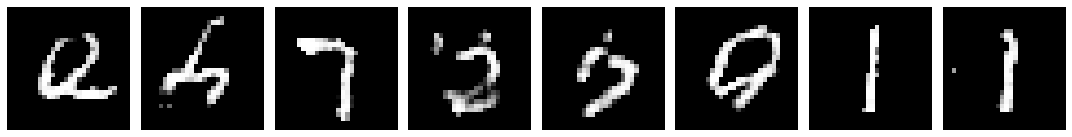

Epoch: 57 	 Discr. Loss Real: [0.7755181789398193, 0.0] 	 Discr. Loss Fake: [0.6137453317642212, 1.0] 	 DCGAN Loss: [0.7920290231704712, 0.0]
Time:  13.152260303497314


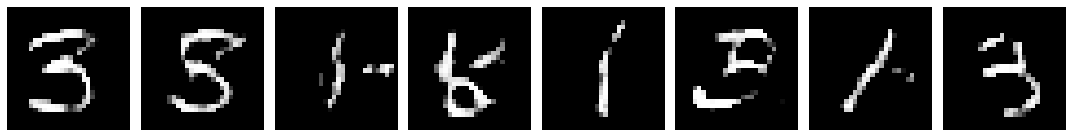

Epoch: 58 	 Discr. Loss Real: [0.7757920622825623, 0.0] 	 Discr. Loss Fake: [0.6375672221183777, 1.0] 	 DCGAN Loss: [0.7717580795288086, 0.0]
Time:  13.21288013458252


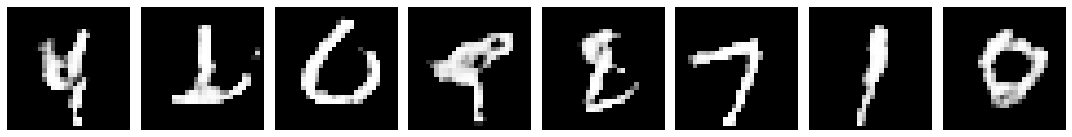

Epoch: 59 	 Discr. Loss Real: [0.76572585105896, 0.0] 	 Discr. Loss Fake: [0.6093305349349976, 1.0] 	 DCGAN Loss: [0.7864105105400085, 0.0]
Time:  13.708030462265015


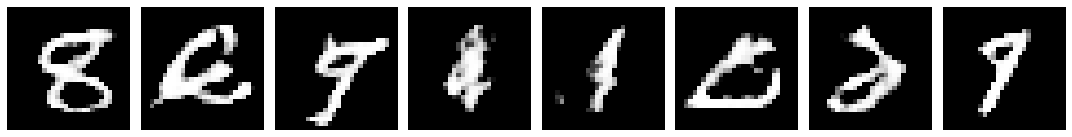

Epoch: 60 	 Discr. Loss Real: [0.7489966154098511, 0.0] 	 Discr. Loss Fake: [0.6237137913703918, 1.0] 	 DCGAN Loss: [0.7805263996124268, 0.0]
Time:  13.345444202423096


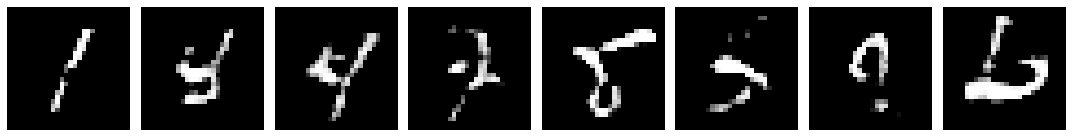

Epoch: 61 	 Discr. Loss Real: [0.7613056302070618, 0.0] 	 Discr. Loss Fake: [0.6316792964935303, 1.0] 	 DCGAN Loss: [0.7825589179992676, 0.0]
Time:  13.81547737121582


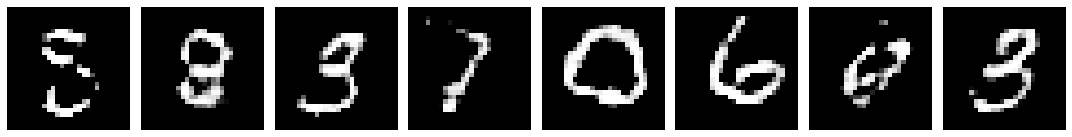

Epoch: 62 	 Discr. Loss Real: [0.7689902782440186, 0.0] 	 Discr. Loss Fake: [0.5924257040023804, 1.0] 	 DCGAN Loss: [0.8205997943878174, 0.0]
Time:  13.233163356781006


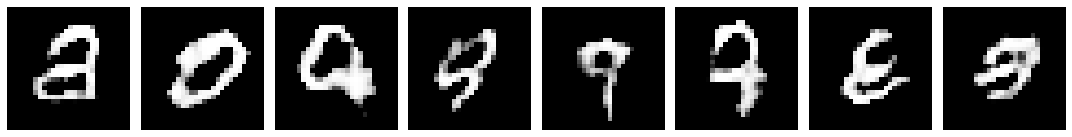

Epoch: 63 	 Discr. Loss Real: [0.7718981504440308, 0.0] 	 Discr. Loss Fake: [0.5820021033287048, 1.0] 	 DCGAN Loss: [0.8341878652572632, 0.0]
Time:  13.103520631790161


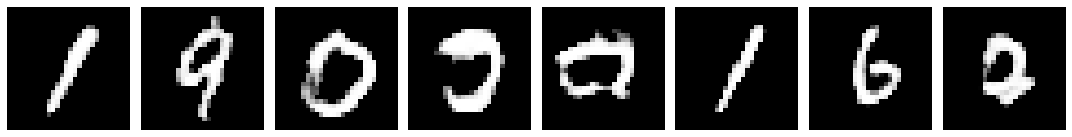

Epoch: 64 	 Discr. Loss Real: [0.7459660172462463, 0.0] 	 Discr. Loss Fake: [0.6476531624794006, 1.0] 	 DCGAN Loss: [0.7585899829864502, 0.0]
Time:  13.293696165084839


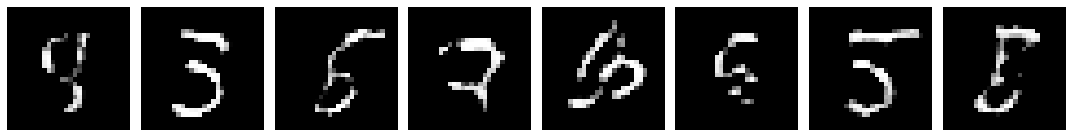

Epoch: 65 	 Discr. Loss Real: [0.745101273059845, 0.0] 	 Discr. Loss Fake: [0.5891933441162109, 1.0] 	 DCGAN Loss: [0.8273962736129761, 0.0]
Time:  13.30979037284851


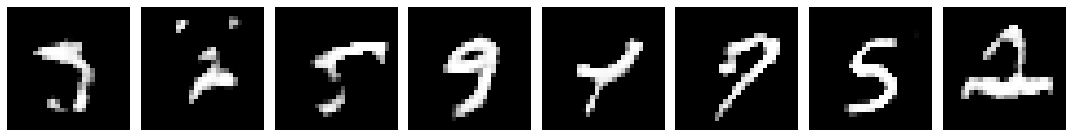

Epoch: 66 	 Discr. Loss Real: [0.7588708400726318, 0.0] 	 Discr. Loss Fake: [0.604422926902771, 1.0] 	 DCGAN Loss: [0.808587372303009, 0.0]
Time:  13.333070278167725


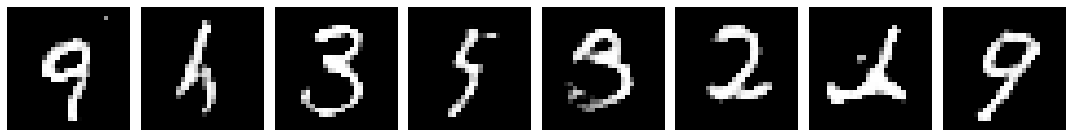

Epoch: 67 	 Discr. Loss Real: [0.7915136218070984, 0.0] 	 Discr. Loss Fake: [0.5740012526512146, 1.0] 	 DCGAN Loss: [0.8486053943634033, 0.0]
Time:  13.235962629318237


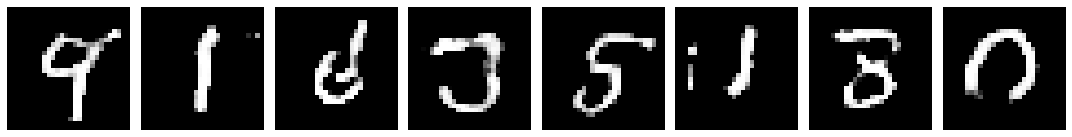

Epoch: 68 	 Discr. Loss Real: [0.7535554766654968, 0.0] 	 Discr. Loss Fake: [0.6243215203285217, 1.0] 	 DCGAN Loss: [0.7827731370925903, 0.0]
Time:  13.187156677246094


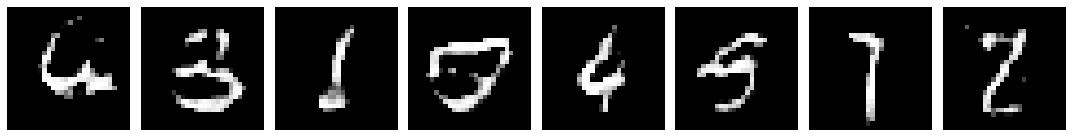

Epoch: 69 	 Discr. Loss Real: [0.7092928886413574, 0.0] 	 Discr. Loss Fake: [0.6207595467567444, 1.0] 	 DCGAN Loss: [0.7821265459060669, 0.0]
Time:  13.334614276885986


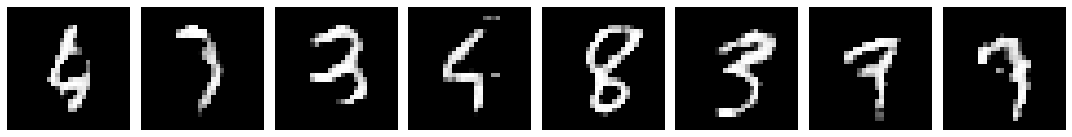

Epoch: 70 	 Discr. Loss Real: [0.7712314128875732, 0.0] 	 Discr. Loss Fake: [0.6243082284927368, 1.0] 	 DCGAN Loss: [0.801665186882019, 0.0]
Time:  13.477088212966919


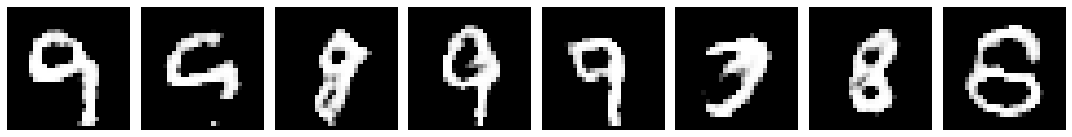

Epoch: 71 	 Discr. Loss Real: [0.7894352674484253, 0.0] 	 Discr. Loss Fake: [0.6096522808074951, 1.0] 	 DCGAN Loss: [0.8090924024581909, 0.0]
Time:  13.586667776107788


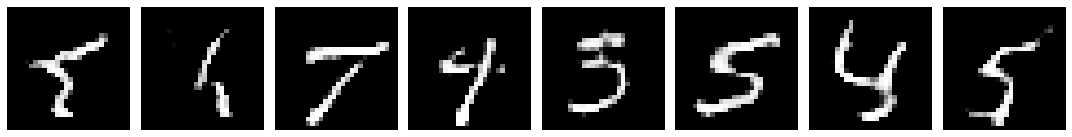

Epoch: 72 	 Discr. Loss Real: [0.7711671590805054, 0.0] 	 Discr. Loss Fake: [0.5999305844306946, 1.0] 	 DCGAN Loss: [0.8065584301948547, 0.0]
Time:  13.209254026412964


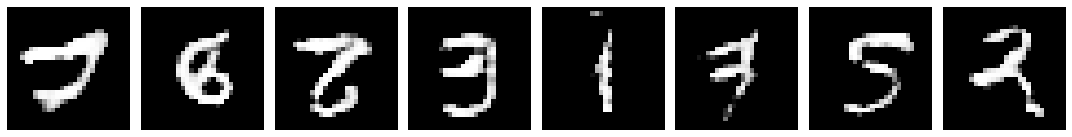

Epoch: 73 	 Discr. Loss Real: [0.7879579067230225, 0.0] 	 Discr. Loss Fake: [0.5858662128448486, 1.0] 	 DCGAN Loss: [0.8211458325386047, 0.0]
Time:  13.22171425819397


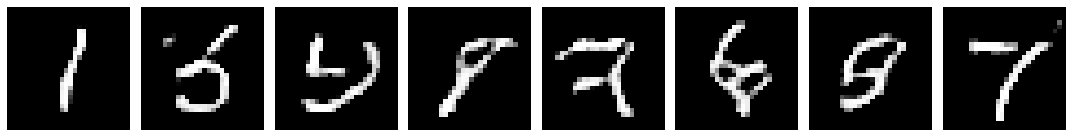

Epoch: 74 	 Discr. Loss Real: [0.7611308097839355, 0.0] 	 Discr. Loss Fake: [0.6267591714859009, 1.0] 	 DCGAN Loss: [0.7966706156730652, 0.0]
Time:  13.281402111053467


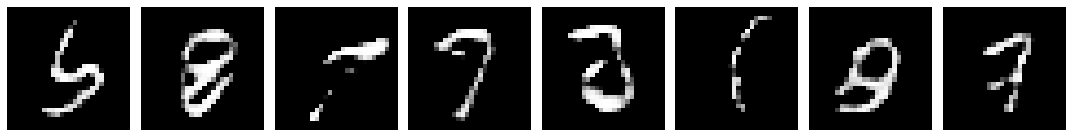

Epoch: 75 	 Discr. Loss Real: [0.7489713430404663, 0.0] 	 Discr. Loss Fake: [0.6270171999931335, 1.0] 	 DCGAN Loss: [0.7769760489463806, 0.0]
Time:  13.458697080612183


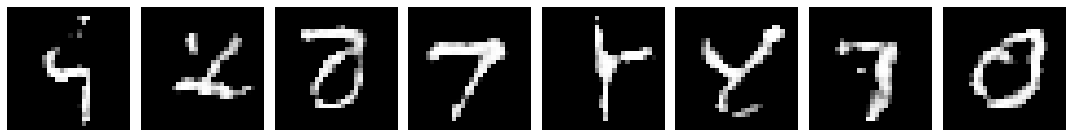

Epoch: 76 	 Discr. Loss Real: [0.7902788519859314, 0.0] 	 Discr. Loss Fake: [0.5630494356155396, 1.0] 	 DCGAN Loss: [0.8643277287483215, 0.0]
Time:  13.230189085006714


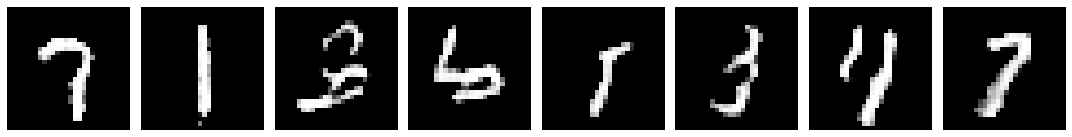

Epoch: 77 	 Discr. Loss Real: [0.7845182418823242, 0.0] 	 Discr. Loss Fake: [0.5857846140861511, 1.0] 	 DCGAN Loss: [0.8422076106071472, 0.0]
Time:  13.170782566070557


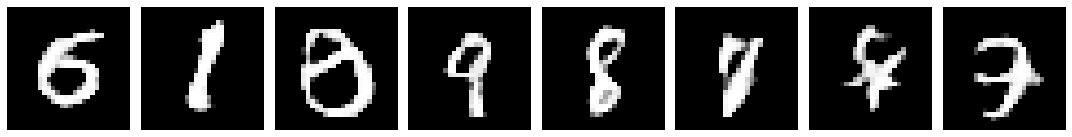

Epoch: 78 	 Discr. Loss Real: [0.7795368432998657, 0.0] 	 Discr. Loss Fake: [0.6009557247161865, 1.0] 	 DCGAN Loss: [0.8259541392326355, 0.0]
Time:  13.25998592376709


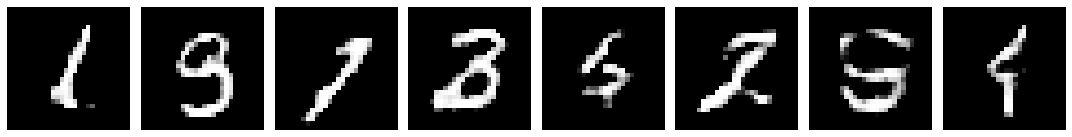

Epoch: 79 	 Discr. Loss Real: [0.7499944567680359, 0.0] 	 Discr. Loss Fake: [0.598694920539856, 1.0] 	 DCGAN Loss: [0.8285677433013916, 0.0]
Time:  13.35269832611084


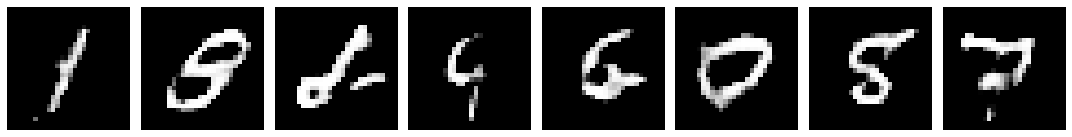

Epoch: 80 	 Discr. Loss Real: [0.7900619506835938, 0.0] 	 Discr. Loss Fake: [0.5904200077056885, 1.0] 	 DCGAN Loss: [0.818576455116272, 0.0]
Time:  13.329070568084717


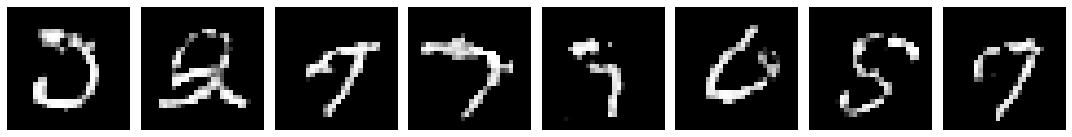

Epoch: 81 	 Discr. Loss Real: [0.7768884897232056, 0.0] 	 Discr. Loss Fake: [0.6011195182800293, 1.0] 	 DCGAN Loss: [0.8171234130859375, 0.0]
Time:  13.850677251815796


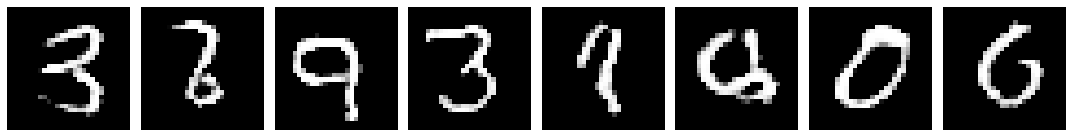

Epoch: 82 	 Discr. Loss Real: [0.7675155401229858, 0.0] 	 Discr. Loss Fake: [0.6149885058403015, 1.0] 	 DCGAN Loss: [0.7954068779945374, 0.0]
Time:  13.253656148910522


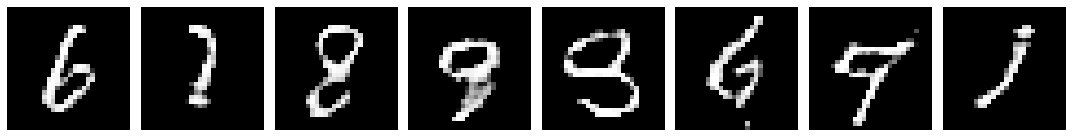

Epoch: 83 	 Discr. Loss Real: [0.7646991610527039, 0.0] 	 Discr. Loss Fake: [0.5914533734321594, 1.0] 	 DCGAN Loss: [0.811270534992218, 0.0]
Time:  13.514752626419067


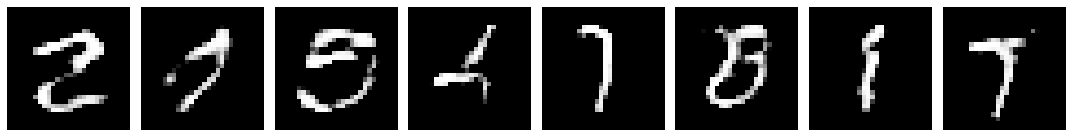

Epoch: 84 	 Discr. Loss Real: [0.7929636240005493, 0.0] 	 Discr. Loss Fake: [0.5966352820396423, 1.0] 	 DCGAN Loss: [0.8314403891563416, 0.0]
Time:  13.186630487442017


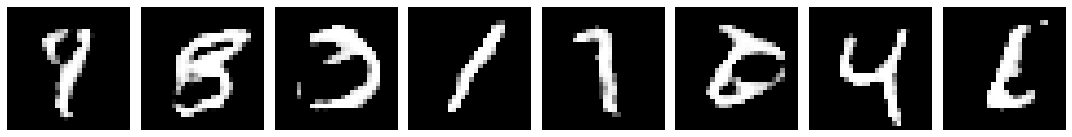

Epoch: 85 	 Discr. Loss Real: [0.7810405492782593, 0.0] 	 Discr. Loss Fake: [0.6075596213340759, 1.0] 	 DCGAN Loss: [0.7964337468147278, 0.0]
Time:  13.183912754058838


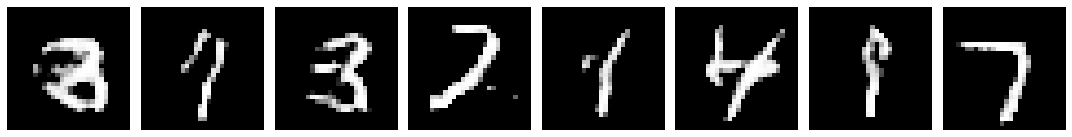

Epoch: 86 	 Discr. Loss Real: [0.7692533731460571, 0.0] 	 Discr. Loss Fake: [0.6135157942771912, 1.0] 	 DCGAN Loss: [0.8171058297157288, 0.0]
Time:  13.25360369682312


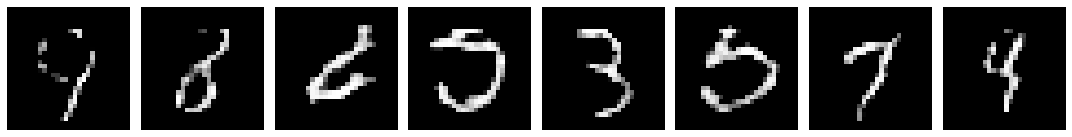

Epoch: 87 	 Discr. Loss Real: [0.7535346746444702, 0.0] 	 Discr. Loss Fake: [0.6053445935249329, 1.0] 	 DCGAN Loss: [0.8213964104652405, 0.0]
Time:  13.372465372085571


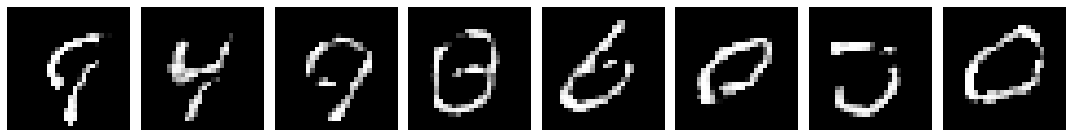

Epoch: 88 	 Discr. Loss Real: [0.7640911340713501, 0.0] 	 Discr. Loss Fake: [0.6085606813430786, 1.0] 	 DCGAN Loss: [0.8105757832527161, 0.0]
Time:  13.273138523101807


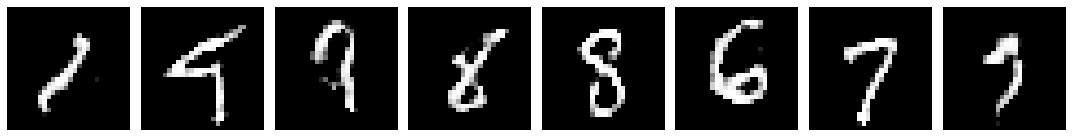

Epoch: 89 	 Discr. Loss Real: [0.7639033198356628, 0.0] 	 Discr. Loss Fake: [0.6141146421432495, 1.0] 	 DCGAN Loss: [0.7812198400497437, 0.0]
Time:  13.27970552444458


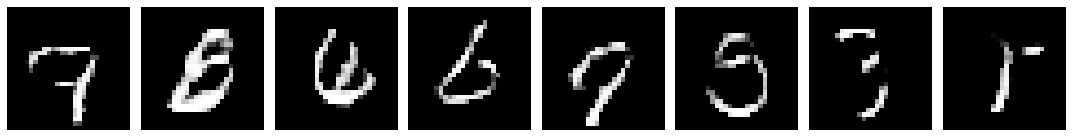

Epoch: 90 	 Discr. Loss Real: [0.7711596488952637, 0.0] 	 Discr. Loss Fake: [0.6039902567863464, 1.0] 	 DCGAN Loss: [0.8239585161209106, 0.0]
Time:  13.596799373626709


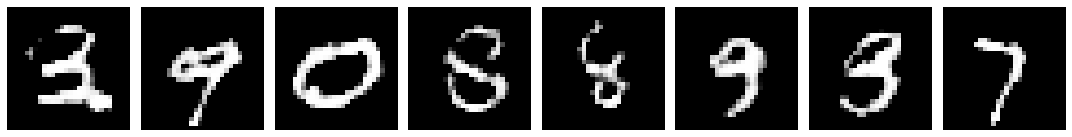

Epoch: 91 	 Discr. Loss Real: [0.7603479623794556, 0.0] 	 Discr. Loss Fake: [0.5934044122695923, 0.99609375] 	 DCGAN Loss: [0.8215844631195068, 0.0]
Time:  13.605690479278564


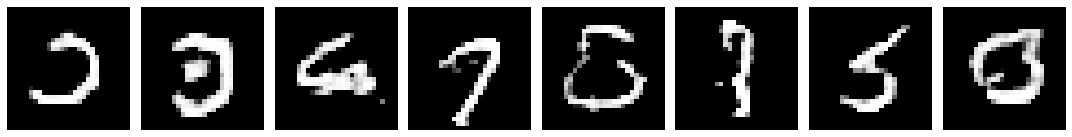

Epoch: 92 	 Discr. Loss Real: [0.7692450284957886, 0.0] 	 Discr. Loss Fake: [0.5975214242935181, 1.0] 	 DCGAN Loss: [0.8218131065368652, 0.0]
Time:  13.283072710037231


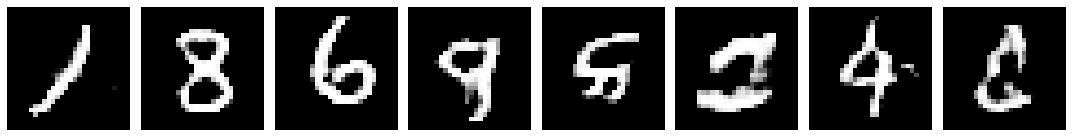

Epoch: 93 	 Discr. Loss Real: [0.7910482883453369, 0.0] 	 Discr. Loss Fake: [0.606472909450531, 1.0] 	 DCGAN Loss: [0.8236250281333923, 0.0]
Time:  13.185628175735474


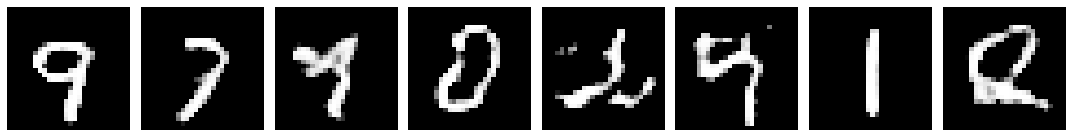

Epoch: 94 	 Discr. Loss Real: [0.7727550268173218, 0.0] 	 Discr. Loss Fake: [0.5862585306167603, 1.0] 	 DCGAN Loss: [0.8258339762687683, 0.0]
Time:  13.167848348617554


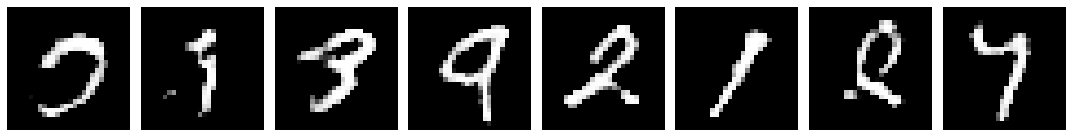

Epoch: 95 	 Discr. Loss Real: [0.7856912016868591, 0.0] 	 Discr. Loss Fake: [0.576789379119873, 1.0] 	 DCGAN Loss: [0.8397535681724548, 0.0]
Time:  13.187052011489868


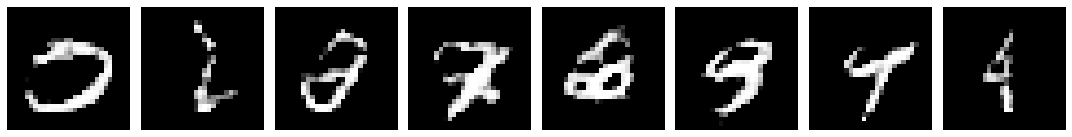

Epoch: 96 	 Discr. Loss Real: [0.7939773797988892, 0.0] 	 Discr. Loss Fake: [0.5840230584144592, 1.0] 	 DCGAN Loss: [0.832939624786377, 0.0]
Time:  13.268513917922974


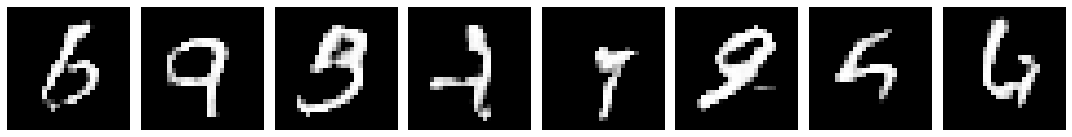

Epoch: 97 	 Discr. Loss Real: [0.7807306051254272, 0.0] 	 Discr. Loss Fake: [0.5761359333992004, 1.0] 	 DCGAN Loss: [0.8100600242614746, 0.0]
Time:  13.299681901931763


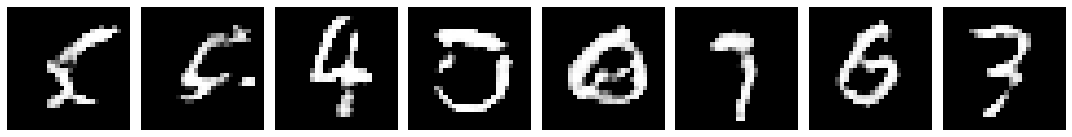

Epoch: 98 	 Discr. Loss Real: [0.7725622057914734, 0.0] 	 Discr. Loss Fake: [0.5940200686454773, 1.0] 	 DCGAN Loss: [0.8281484246253967, 0.0]
Time:  13.20853567123413


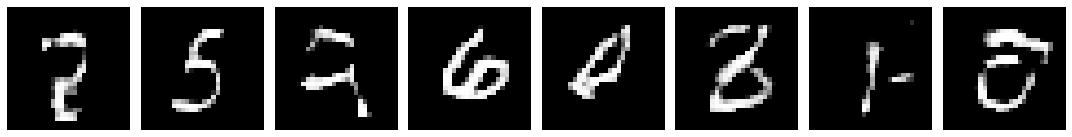

Epoch: 99 	 Discr. Loss Real: [0.7673413753509521, 0.0] 	 Discr. Loss Fake: [0.59444260597229, 1.0] 	 DCGAN Loss: [0.8170367479324341, 0.0]
Time:  13.391279697418213


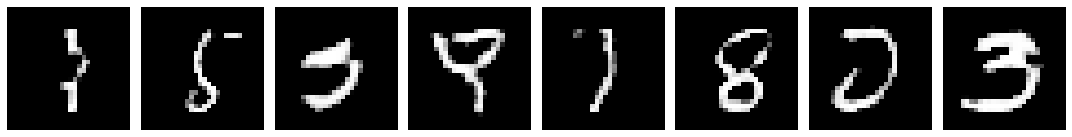

Epoch: 100 	 Discr. Loss Real: [0.7598152160644531, 0.0] 	 Discr. Loss Fake: [0.6163706183433533, 1.0] 	 DCGAN Loss: [0.7931239008903503, 0.0]
Time:  13.450923919677734


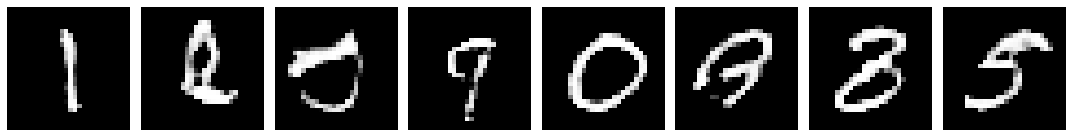

Epoch: 101 	 Discr. Loss Real: [0.7955082058906555, 0.0] 	 Discr. Loss Fake: [0.5729750394821167, 1.0] 	 DCGAN Loss: [0.8399806022644043, 0.0]
Time:  13.596396446228027


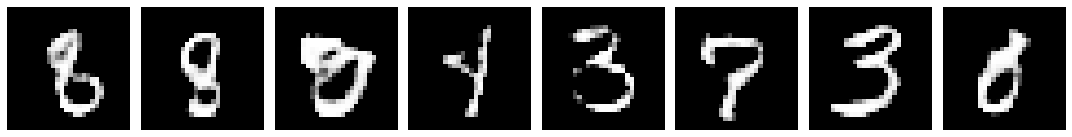

Epoch: 102 	 Discr. Loss Real: [0.7662265300750732, 0.0] 	 Discr. Loss Fake: [0.5958719253540039, 1.0] 	 DCGAN Loss: [0.829882025718689, 0.0]
Time:  13.076080083847046


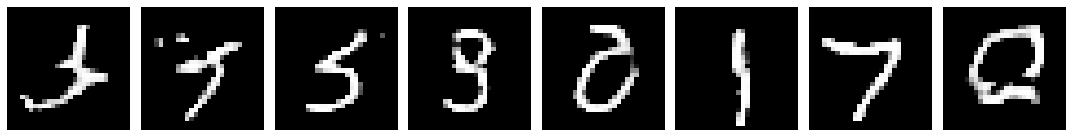

Epoch: 103 	 Discr. Loss Real: [0.7779695987701416, 0.0] 	 Discr. Loss Fake: [0.5951423645019531, 0.99609375] 	 DCGAN Loss: [0.8202940225601196, 0.0]
Time:  13.341458320617676


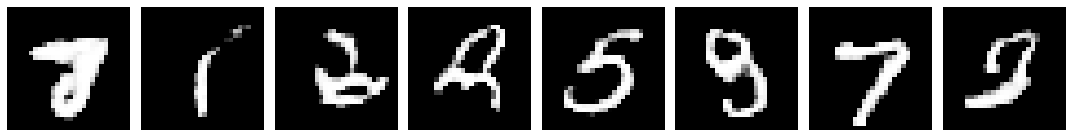

Epoch: 104 	 Discr. Loss Real: [0.7734065055847168, 0.0] 	 Discr. Loss Fake: [0.6012827157974243, 1.0] 	 DCGAN Loss: [0.8284252882003784, 0.0]
Time:  13.7993643283844


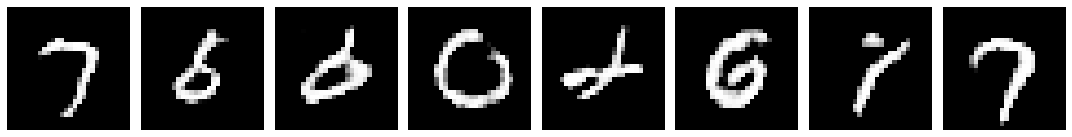

Epoch: 105 	 Discr. Loss Real: [0.7538997530937195, 0.0] 	 Discr. Loss Fake: [0.5937210321426392, 1.0] 	 DCGAN Loss: [0.805009663105011, 0.0]
Time:  13.595561504364014


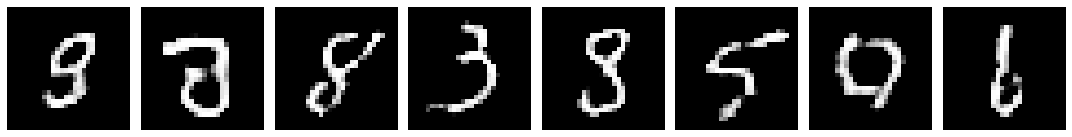

Epoch: 106 	 Discr. Loss Real: [0.7696609497070312, 0.0] 	 Discr. Loss Fake: [0.604625403881073, 1.0] 	 DCGAN Loss: [0.807521641254425, 0.0]
Time:  13.200218200683594


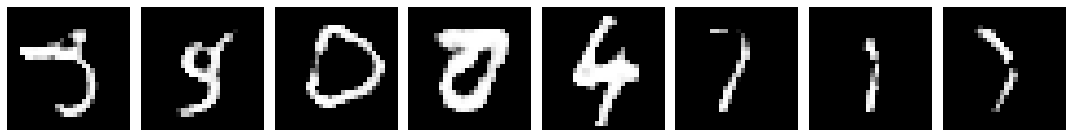

Epoch: 107 	 Discr. Loss Real: [0.7913236618041992, 0.0] 	 Discr. Loss Fake: [0.5553388595581055, 1.0] 	 DCGAN Loss: [0.8627707958221436, 0.0]
Time:  13.273617506027222


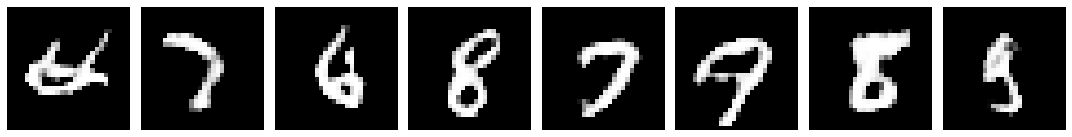

Epoch: 108 	 Discr. Loss Real: [0.7734948396682739, 0.0] 	 Discr. Loss Fake: [0.583669126033783, 1.0] 	 DCGAN Loss: [0.814061164855957, 0.0]
Time:  13.285972833633423


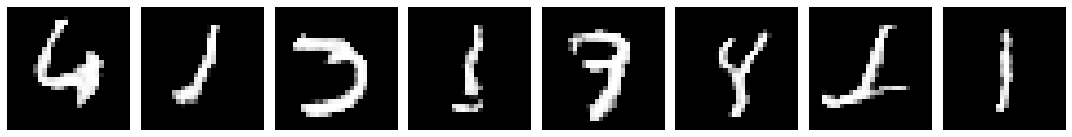

Epoch: 109 	 Discr. Loss Real: [0.7753132581710815, 0.0] 	 Discr. Loss Fake: [0.593123197555542, 1.0] 	 DCGAN Loss: [0.8293115496635437, 0.0]
Time:  13.536983728408813


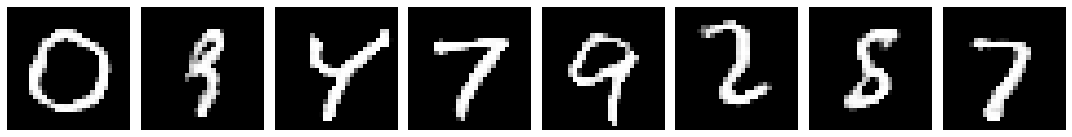

Epoch: 110 	 Discr. Loss Real: [0.7979997992515564, 0.0] 	 Discr. Loss Fake: [0.571955680847168, 1.0] 	 DCGAN Loss: [0.8634239435195923, 0.0]
Time:  13.372058391571045


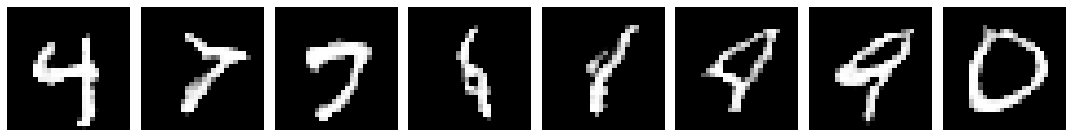

Epoch: 111 	 Discr. Loss Real: [0.791675329208374, 0.0] 	 Discr. Loss Fake: [0.5678526759147644, 1.0] 	 DCGAN Loss: [0.8543787002563477, 0.0]
Time:  13.524994134902954


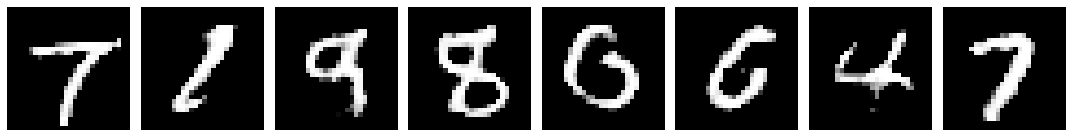

Epoch: 112 	 Discr. Loss Real: [0.7689712643623352, 0.0] 	 Discr. Loss Fake: [0.6016676425933838, 1.0] 	 DCGAN Loss: [0.8287597298622131, 0.0]
Time:  13.208670854568481


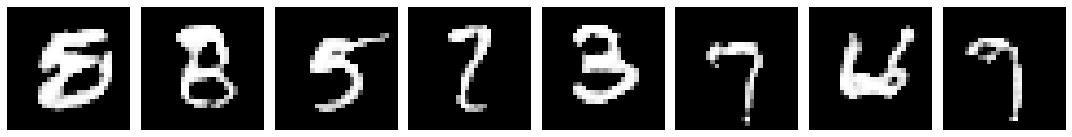

Epoch: 113 	 Discr. Loss Real: [0.7546325325965881, 0.0] 	 Discr. Loss Fake: [0.6089451313018799, 1.0] 	 DCGAN Loss: [0.7961801290512085, 0.0]
Time:  13.276508808135986


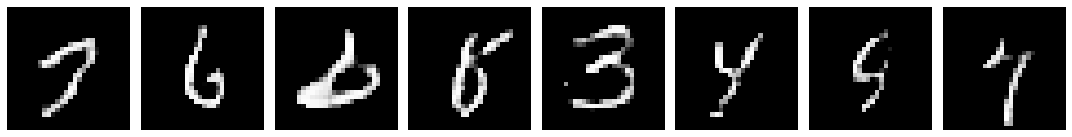

Epoch: 114 	 Discr. Loss Real: [0.7811715602874756, 0.0] 	 Discr. Loss Fake: [0.5969840288162231, 1.0] 	 DCGAN Loss: [0.8221956491470337, 0.0]
Time:  13.388074398040771


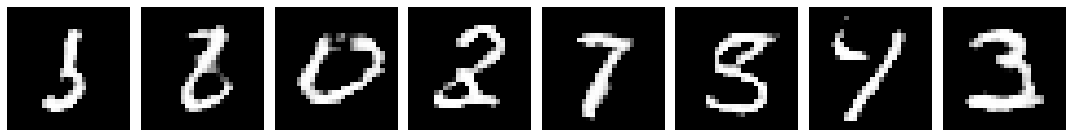

Epoch: 115 	 Discr. Loss Real: [0.7835036516189575, 0.0] 	 Discr. Loss Fake: [0.6033483743667603, 1.0] 	 DCGAN Loss: [0.8258496522903442, 0.0]
Time:  13.268583297729492


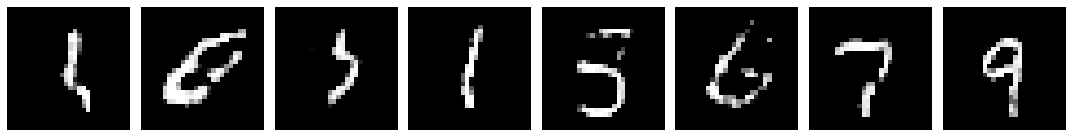

Epoch: 116 	 Discr. Loss Real: [0.7774131298065186, 0.0] 	 Discr. Loss Fake: [0.6263471841812134, 1.0] 	 DCGAN Loss: [0.8013160228729248, 0.0]
Time:  13.09598970413208


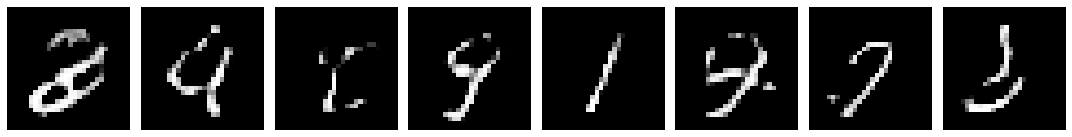

Epoch: 117 	 Discr. Loss Real: [0.7926538586616516, 0.0] 	 Discr. Loss Fake: [0.5803261399269104, 1.0] 	 DCGAN Loss: [0.8404088020324707, 0.0]
Time:  13.084818124771118


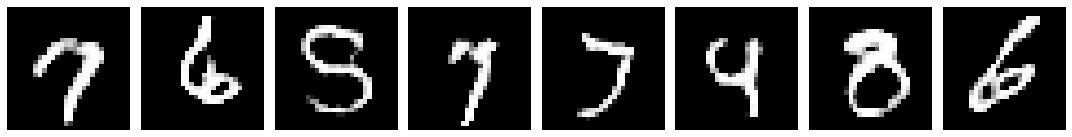

Epoch: 118 	 Discr. Loss Real: [0.7629909515380859, 0.0] 	 Discr. Loss Fake: [0.6175369620323181, 1.0] 	 DCGAN Loss: [0.7919884324073792, 0.0]
Time:  13.19179630279541


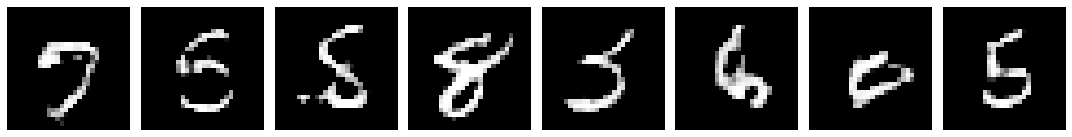

Epoch: 119 	 Discr. Loss Real: [0.7506087422370911, 0.0] 	 Discr. Loss Fake: [0.6066038608551025, 1.0] 	 DCGAN Loss: [0.808576762676239, 0.0]
Time:  13.214726686477661


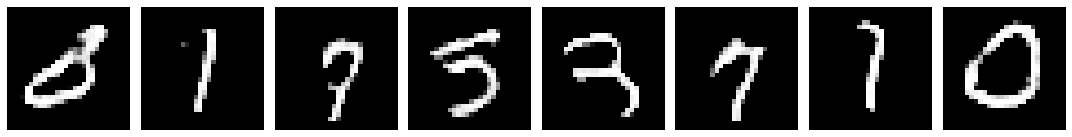

Epoch: 120 	 Discr. Loss Real: [0.7919586896896362, 0.0] 	 Discr. Loss Fake: [0.5848251581192017, 1.0] 	 DCGAN Loss: [0.8466092944145203, 0.0]
Time:  13.247440338134766


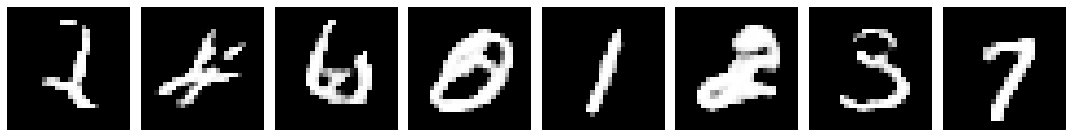

Epoch: 121 	 Discr. Loss Real: [0.793885350227356, 0.0] 	 Discr. Loss Fake: [0.5815717577934265, 1.0] 	 DCGAN Loss: [0.8392770290374756, 0.0]
Time:  13.343059778213501


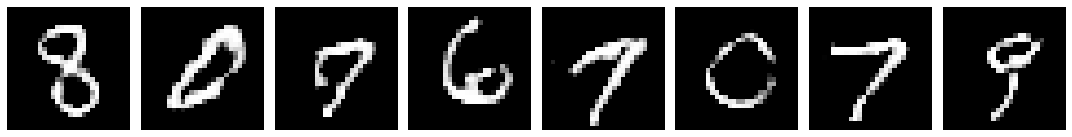

Epoch: 122 	 Discr. Loss Real: [0.7971190214157104, 0.0] 	 Discr. Loss Fake: [0.5730443000793457, 1.0] 	 DCGAN Loss: [0.8279587626457214, 0.0]
Time:  13.145003080368042


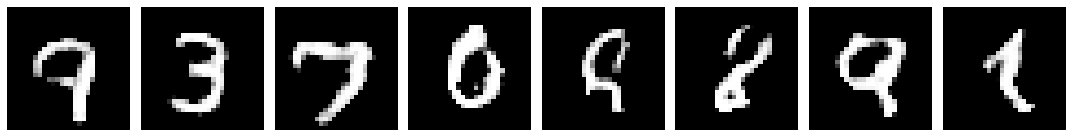

Epoch: 123 	 Discr. Loss Real: [0.7661486864089966, 0.0] 	 Discr. Loss Fake: [0.6124711036682129, 1.0] 	 DCGAN Loss: [0.7959771752357483, 0.0]
Time:  13.131785869598389


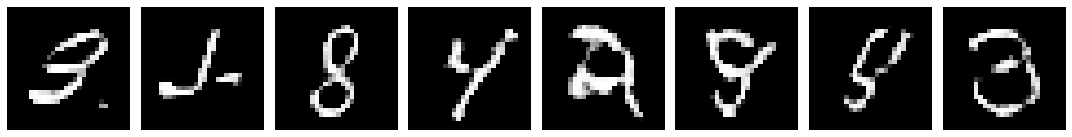

Epoch: 124 	 Discr. Loss Real: [0.78448086977005, 0.0] 	 Discr. Loss Fake: [0.5745538473129272, 1.0] 	 DCGAN Loss: [0.8494783639907837, 0.0]
Time:  13.041255712509155


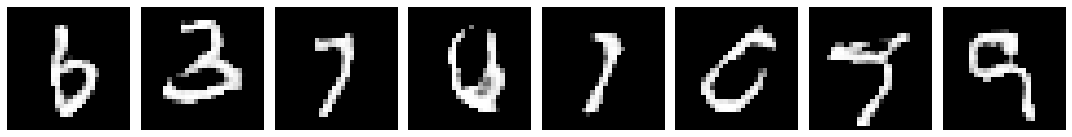

Epoch: 125 	 Discr. Loss Real: [0.7797509431838989, 0.0] 	 Discr. Loss Fake: [0.5772113800048828, 1.0] 	 DCGAN Loss: [0.8388803601264954, 0.0]
Time:  13.216687440872192


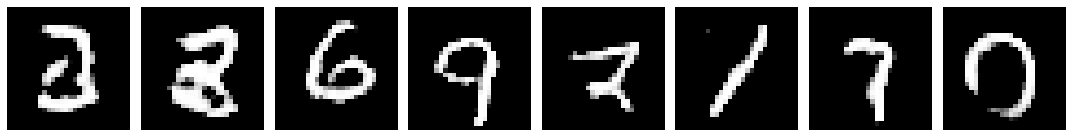

Epoch: 126 	 Discr. Loss Real: [0.7461779713630676, 0.0] 	 Discr. Loss Fake: [0.5964436531066895, 1.0] 	 DCGAN Loss: [0.8041509985923767, 0.0]
Time:  13.342013120651245


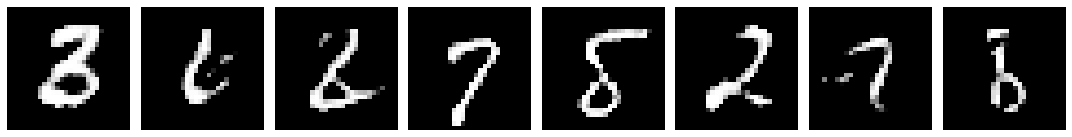

Epoch: 127 	 Discr. Loss Real: [0.7566569447517395, 0.0] 	 Discr. Loss Fake: [0.6014329791069031, 0.99609375] 	 DCGAN Loss: [0.8146733045578003, 0.0]
Time:  13.435345649719238


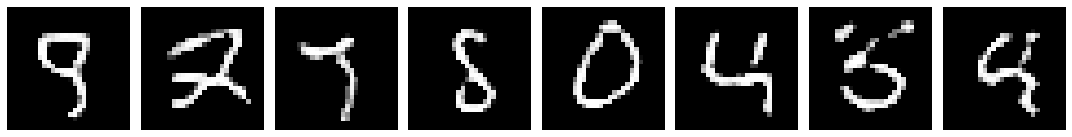

Epoch: 128 	 Discr. Loss Real: [0.8138328790664673, 0.0] 	 Discr. Loss Fake: [0.5703256130218506, 1.0] 	 DCGAN Loss: [0.8535270094871521, 0.0]
Time:  13.39713978767395


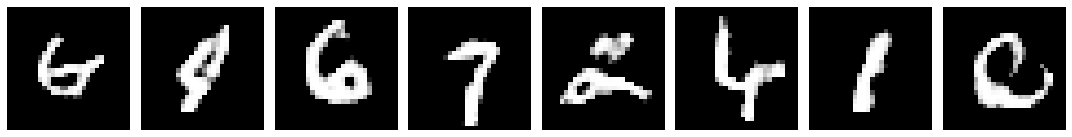

Epoch: 129 	 Discr. Loss Real: [0.7753427028656006, 0.0] 	 Discr. Loss Fake: [0.5956855416297913, 1.0] 	 DCGAN Loss: [0.8051192164421082, 0.00390625]
Time:  13.236196041107178


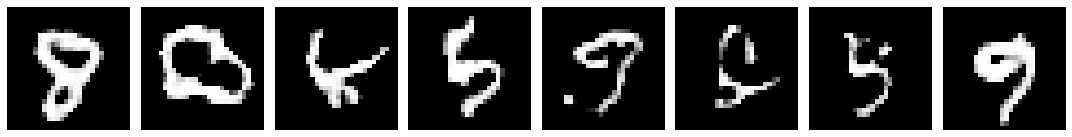

Epoch: 130 	 Discr. Loss Real: [0.7849111557006836, 0.0] 	 Discr. Loss Fake: [0.5610107183456421, 1.0] 	 DCGAN Loss: [0.8874841332435608, 0.0]
Time:  13.339538812637329


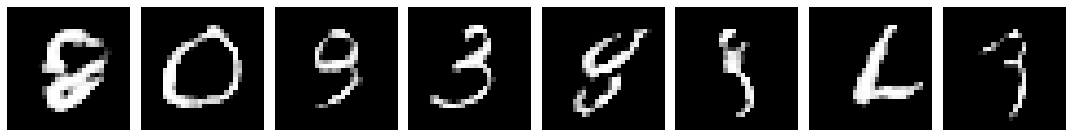

Epoch: 131 	 Discr. Loss Real: [0.762152373790741, 0.0] 	 Discr. Loss Fake: [0.5979063510894775, 0.99609375] 	 DCGAN Loss: [0.8081403970718384, 0.0]
Time:  13.476577997207642


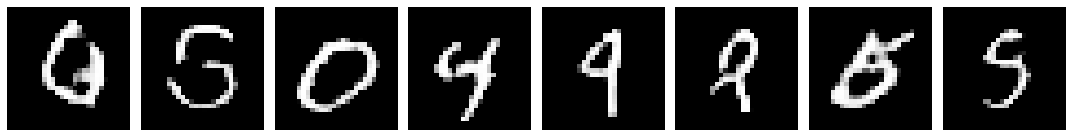

Epoch: 132 	 Discr. Loss Real: [0.7686082124710083, 0.0] 	 Discr. Loss Fake: [0.5956846475601196, 1.0] 	 DCGAN Loss: [0.8113940358161926, 0.0]
Time:  13.060344219207764


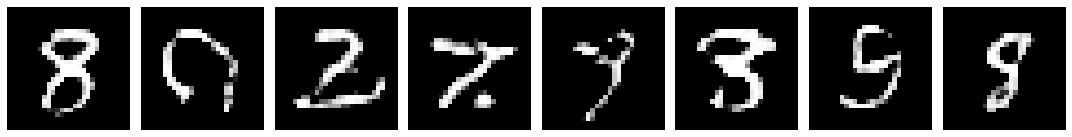

Epoch: 133 	 Discr. Loss Real: [0.7732661962509155, 0.0] 	 Discr. Loss Fake: [0.5955376029014587, 1.0] 	 DCGAN Loss: [0.8269783854484558, 0.0]
Time:  13.129485130310059


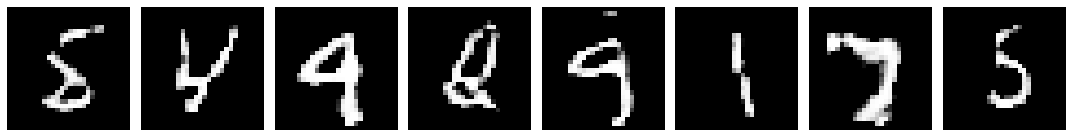

Epoch: 134 	 Discr. Loss Real: [0.7690113186836243, 0.0] 	 Discr. Loss Fake: [0.5913270711898804, 1.0] 	 DCGAN Loss: [0.8166855573654175, 0.0]
Time:  13.040307998657227


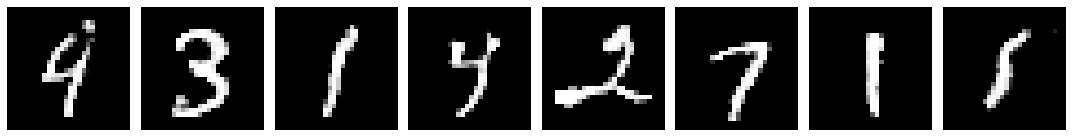

Epoch: 135 	 Discr. Loss Real: [0.7730095386505127, 0.0] 	 Discr. Loss Fake: [0.5691161155700684, 1.0] 	 DCGAN Loss: [0.8383471965789795, 0.0]
Time:  13.326904058456421


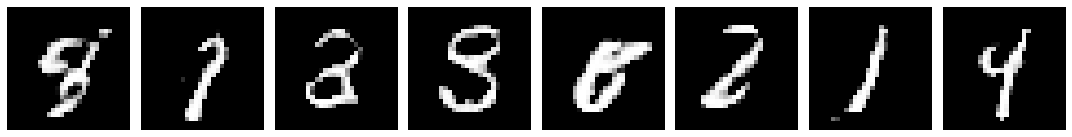

Epoch: 136 	 Discr. Loss Real: [0.7504304647445679, 0.0] 	 Discr. Loss Fake: [0.613483726978302, 1.0] 	 DCGAN Loss: [0.8125388026237488, 0.0]
Time:  13.250812530517578


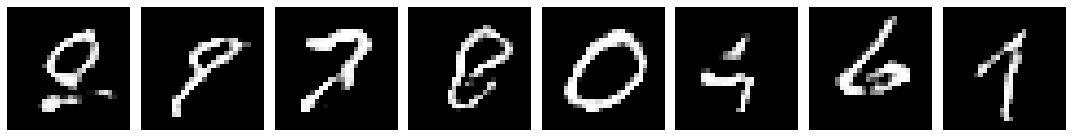

Epoch: 137 	 Discr. Loss Real: [0.802213191986084, 0.0] 	 Discr. Loss Fake: [0.5682030916213989, 1.0] 	 DCGAN Loss: [0.8663485050201416, 0.0]
Time:  13.239176273345947


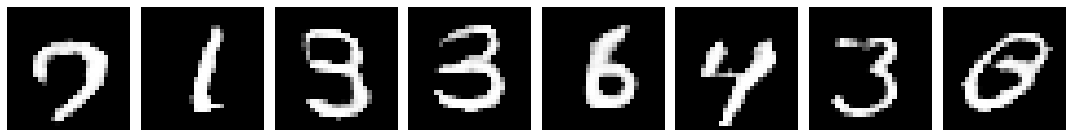

Epoch: 138 	 Discr. Loss Real: [0.768632173538208, 0.0] 	 Discr. Loss Fake: [0.5933500528335571, 1.0] 	 DCGAN Loss: [0.8160800933837891, 0.0]
Time:  13.088057041168213


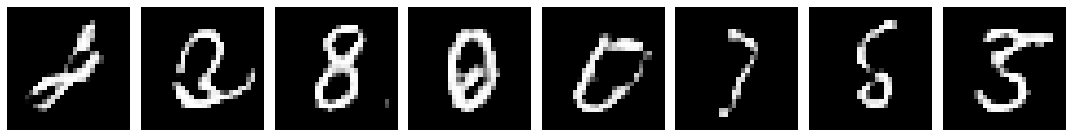

Epoch: 139 	 Discr. Loss Real: [0.7666444778442383, 0.0] 	 Discr. Loss Fake: [0.6008976697921753, 1.0] 	 DCGAN Loss: [0.8018460273742676, 0.0]
Time:  13.296873331069946


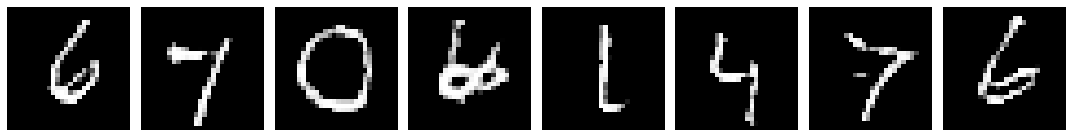

Epoch: 140 	 Discr. Loss Real: [0.8123802542686462, 0.0] 	 Discr. Loss Fake: [0.544630765914917, 1.0] 	 DCGAN Loss: [0.8787412643432617, 0.0]
Time:  13.266222476959229


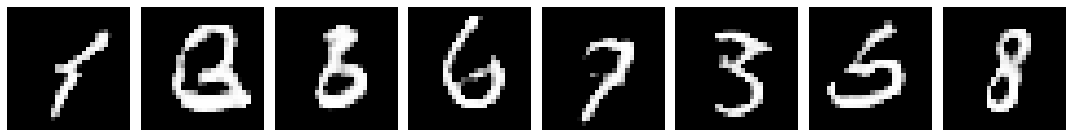

Epoch: 141 	 Discr. Loss Real: [0.7626887559890747, 0.0] 	 Discr. Loss Fake: [0.6092332601547241, 1.0] 	 DCGAN Loss: [0.8081535696983337, 0.0]
Time:  13.39844799041748


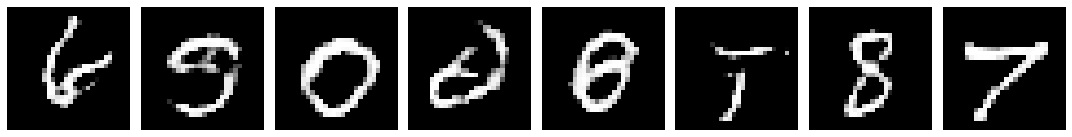

Epoch: 142 	 Discr. Loss Real: [0.8124743700027466, 0.0] 	 Discr. Loss Fake: [0.5539436340332031, 1.0] 	 DCGAN Loss: [0.8942137360572815, 0.0]
Time:  13.029972553253174


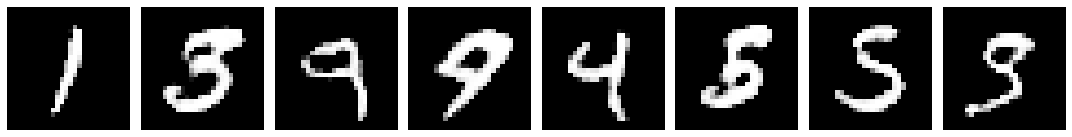

Epoch: 143 	 Discr. Loss Real: [0.7605500817298889, 0.0] 	 Discr. Loss Fake: [0.602479100227356, 1.0] 	 DCGAN Loss: [0.8193421959877014, 0.0]
Time:  13.05824589729309


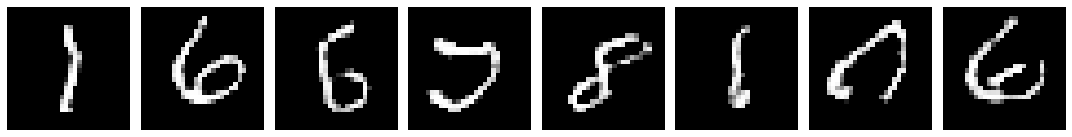

Epoch: 144 	 Discr. Loss Real: [0.7605792880058289, 0.0] 	 Discr. Loss Fake: [0.606663703918457, 1.0] 	 DCGAN Loss: [0.8141012191772461, 0.0078125]
Time:  13.167821645736694


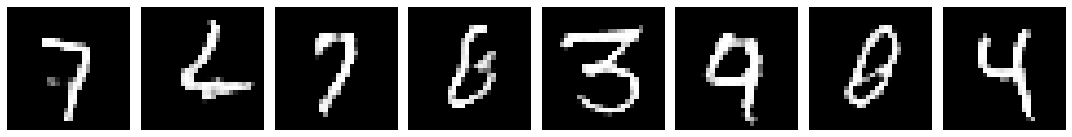

Epoch: 145 	 Discr. Loss Real: [0.7938973307609558, 0.0] 	 Discr. Loss Fake: [0.5767939686775208, 1.0] 	 DCGAN Loss: [0.8646470308303833, 0.0]
Time:  13.335607290267944


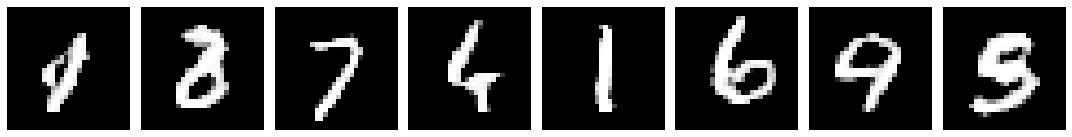

Epoch: 146 	 Discr. Loss Real: [0.7550743222236633, 0.0] 	 Discr. Loss Fake: [0.6054375171661377, 1.0] 	 DCGAN Loss: [0.8127443790435791, 0.0]
Time:  13.081904649734497


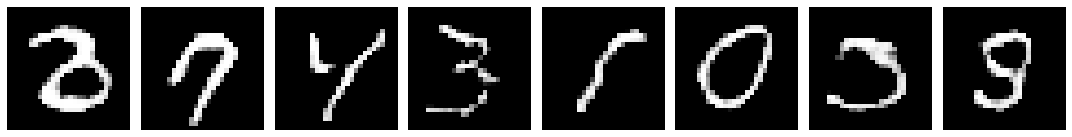

Epoch: 147 	 Discr. Loss Real: [0.7885737419128418, 0.0] 	 Discr. Loss Fake: [0.5799031257629395, 1.0] 	 DCGAN Loss: [0.8627066016197205, 0.0]
Time:  13.113052606582642


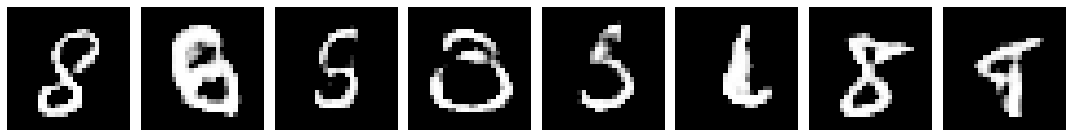

Epoch: 148 	 Discr. Loss Real: [0.7738310098648071, 0.0] 	 Discr. Loss Fake: [0.6102302074432373, 1.0] 	 DCGAN Loss: [0.8011415600776672, 0.0]
Time:  13.334389448165894


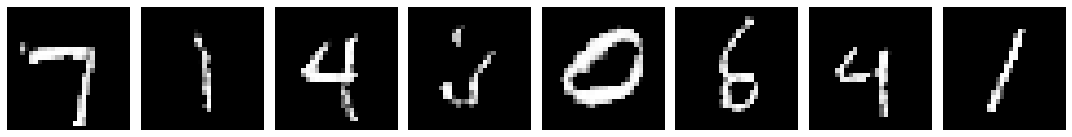

Epoch: 149 	 Discr. Loss Real: [0.7867386937141418, 0.0] 	 Discr. Loss Fake: [0.5667226314544678, 1.0] 	 DCGAN Loss: [0.8558114171028137, 0.0]
Time:  13.511635065078735


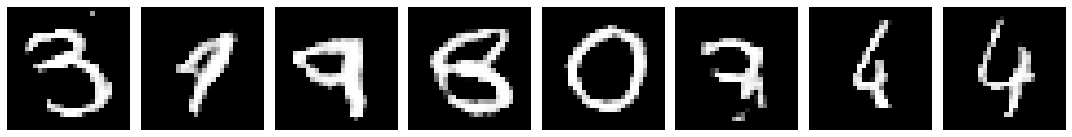

In [0]:
BATCH_SIZE = 256
epochs = 150 #70
noise_dim = (100,) #(128,)
losses = {"D":[], "G":[]}

y_smoother = 0.1
y_real = tf.ones((BATCH_SIZE,1))
y_fake = tf.zeros((BATCH_SIZE,1))


for epoch in range(epochs):
    
    start = time.time()
    
    i = 0
    for x_real in train_dataset:
        noise = tf.random.normal(shape=(BATCH_SIZE, noise_dim[0]))
        x_fake = g.predict_on_batch(noise)
        
        # train discriminator
        d_loss_real = d.train_on_batch(x_real, y_real - y_smoother)
        
        d_loss_fake = d.train_on_batch(x_fake, y_fake)
        
        # train generator
        noise = tf.random.normal(shape=(BATCH_SIZE, noise_dim[0]))
        dcgan_loss = gan.train_on_batch(noise, y_real)
        
    # Only store losses from final
    losses["D"].append((d_loss_real[0]+d_loss_fake[0])/2.)
    losses["G"].append(dcgan_loss[0])    
        
    print(f'Epoch: {epoch} \t Discr. Loss Real: {d_loss_real} \t Discr. Loss Fake: {d_loss_fake} \t DCGAN Loss: {dcgan_loss}')
    print("Time: ", time.time()-start) 
    
    show_images(x_fake[:8])
    
    
    

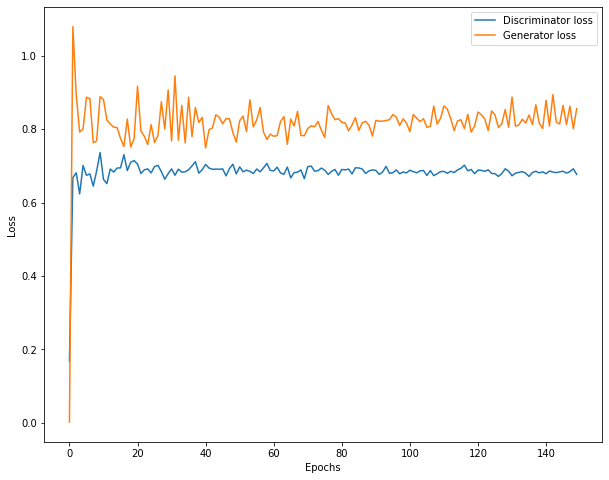

In [0]:
def plot_loss(losses):
    
    d_loss = [v for v in losses["D"]]
    g_loss = [v for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_loss(losses)